# **REINFORCE with Local Differential Privacy  on Cartpole**
## In this notebook, we propose a local differentially private REINFORCE by disturbing observations i.e. the states seen by the model. We add a gaussian noise to the states before feeding the REINFORCE.

## Acknowledgement

Code adapted from [this notebook](https://github.com/bentrevett/pytorch-rl/blob/master/dqn_working.ipynb).


## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym
import os

## Initialize environments

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

In [ ]:
MEAN = torch.zeros(4)
STD = torch.tensor([0.55, 0.39, 0.05, 0.32])

## Seed

In [ ]:
SEED = 42

train_env.reset(seed=SEED);
test_env.reset(seed=SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [ ]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

## Training

In [1]:
def train(env, policy, optimizer, discount_factor, sigma=None):
    
    policy.train()
    
    log_prob_actions = []
    rewards = []
    done = False
    episode_reward = 0
    n_samples = 0
    state, _ = env.reset()
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)

        # Add noise on the state
        if sigma:
            noise = torch.normal(mean=MEAN, std=sigma*STD)
            state += noise

        action_pred = policy(state)
        
        action_prob = F.softmax(action_pred, dim=-1)
                
        dist = distributions.Categorical(action_prob)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        log_prob_actions.append(log_prob_action)
        rewards.append(reward)
        n_samples += 1
        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
        
    returns = calculate_returns(rewards, discount_factor)
        
    loss = update_policy(returns, log_prob_actions, optimizer)

    return loss, episode_reward, n_samples

In [ ]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [ ]:
def update_policy(returns, log_prob_actions, optimizer):
    
    returns = returns.detach()
    
    loss = - (returns * log_prob_actions).sum()
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    return loss.item()

In [ ]:
def evaluate(env, policy, sigma=None):
    
    policy.eval()
    
    done = False
    episode_reward = 0

    state, _ = env.reset()

    while not done:     
        state = torch.FloatTensor(state).unsqueeze(0)
        
        with torch.no_grad():
        
            action_pred = policy(state)
        
            action_prob = F.softmax(action_pred, dim = -1)
                            
        action = torch.argmax(action_prob, dim = -1)
       
        state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        episode_reward += reward
        
    return episode_reward

In [ ]:
total_nb_episodes = 1000
gamma = 0.99

lr = 0.01
n_trials = 25

noise_levels = [0, 0.01, 0.1, 0.2, 0.3, 0.5, 2, 5] 

print_every = 25

run_0 = 100
nb_runs = 100

os.makedirs('experiments/reinforce_LDP', exist_ok=True)

for run in range(nb_runs):
    print('Starting run {}: '.format(run))
    train_rewards = np.zeros((len(noise_levels), total_nb_episodes))
    test_rewards = np.zeros((len(noise_levels), total_nb_episodes))

    for i, sigma in enumerate(noise_levels):
        train_env.reset(seed=SEED);
        test_env.reset(seed=SEED+1);

        print("-------------- Noise: sigma = {} ---------------\n".format(sigma))
        policy = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
        policy.apply(init_weights)

        optimizer = optim.Adam(policy.parameters(), lr=lr)
        convergence = False

        for episode in range(total_nb_episodes):
            if not convergence:
                loss, train_reward, _ = train(train_env, policy,
                                                      discount_factor = gamma, optimizer=optimizer, sigma=sigma)
                test_reward = evaluate(test_env, policy, sigma=sigma)

                train_rewards[i][episode] = train_reward
                test_rewards[i][episode] = test_reward

                mean_train_rewards = np.mean(train_rewards[i][episode-n_trials:episode+1])
                mean_test_rewards = np.mean(test_rewards[i][episode-n_trials:episode+1])

                convergence = (mean_test_rewards) >= 475
                if convergence: print("Achieved convergence")
            else:
                train_rewards[i][episode] = train_rewards[i][episode-1]
                test_rewards[i][episode] = test_rewards[i][episode-1]

            if episode % print_every == 0:
                print(f'| Episode: {episode:3} | Train Reward: {train_reward:5.1f} | Test Reward: {test_reward:5.1f} |')
        
    np.save('experiments/reinforce_LDP/rewards_run_{}.npy'.format(run_0 + run), test_rewards)


Starting run 0: 
-------------- Noise: sigma = 0 ---------------

| Episode:   0 | Train Reward:  29.0 | Test Reward:  43.0 |
| Episode:  25 | Train Reward:  48.0 | Test Reward:  41.0 |
| Episode:  50 | Train Reward:  13.0 | Test Reward:  40.0 |
| Episode:  75 | Train Reward:  96.0 | Test Reward: 134.0 |
| Episode: 100 | Train Reward:  98.0 | Test Reward: 367.0 |
| Episode: 125 | Train Reward: 255.0 | Test Reward: 243.0 |
| Episode: 150 | Train Reward: 402.0 | Test Reward: 235.0 |
| Episode: 175 | Train Reward:  97.0 | Test Reward: 102.0 |
| Episode: 200 | Train Reward: 148.0 | Test Reward: 187.0 |
| Episode: 225 | Train Reward: 285.0 | Test Reward: 431.0 |
Achieved convergence
| Episode: 250 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 37

| Episode:  25 | Train Reward:  54.0 | Test Reward:  57.0 |
| Episode:  50 | Train Reward: 140.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 225.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 375 | Train Reward:  45.0 | Test Reward:  33.0 |
| Episode: 400 | Train Reward:  26.0 | Test Reward:  37.0 |
| Episode: 425 | Train Reward:  31.0 | Test Reward: 111.0 |
| Episode: 450 | Train Reward:  15.0 | Test Reward:  77.0 |
| Episode: 475 | Train Reward:  30.0 | Test Reward:  91.0 |
| Episode: 500 | Train Reward:  38.0 | Test Reward:  92.0 |
| Episode: 525 | Train Reward:  25.0 | Test Reward:  34.0 |
| Episode: 550 | Train Reward:  38.0 | Test Reward: 108.0 |
| Episode: 575 | Train Reward:  21.0 | Test Reward:  31.0 |
| Episode: 600 | Train Reward:  25.0 | Test Reward:  35.0 |
| Episode: 625 | Train Reward:  34.0 | Test Reward:  55.0 |
| Episode: 650 | Train Reward:  21.0 | Test Reward: 192.0 |
| Episode: 675 | Train Reward:  17.0 | Test Reward:  61.0 |
| Episode: 700 | Train Reward:  43.0 | Test Reward: 209.0 |
| Episode: 725 | Train Reward:  40.0 | Test Reward:  63.0 |
| Episode: 750 | Train Reward:  19.0 | Test Reward:  45.0 |
| Episode: 775 | Train Reward:  24.0 | T

| Episode:  25 | Train Reward:  91.0 | Test Reward:  56.0 |
| Episode:  50 | Train Reward:  93.0 | Test Reward: 186.0 |
| Episode:  75 | Train Reward:  91.0 | Test Reward: 248.0 |
| Episode: 100 | Train Reward: 264.0 | Test Reward: 221.0 |
| Episode: 125 | Train Reward: 144.0 | Test Reward: 187.0 |
| Episode: 150 | Train Reward: 170.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 210.0 | Test Reward: 228.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  21.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  19.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  20.0 | Test Reward:  35.0 |
| Episode: 100 | Train Reward:  34.0 | Test Reward:  41.0 |
| Episode: 125 | Train Reward:  14.0 | Test Reward:  40.0 |
| Episode: 150 | Train Reward:  20.0 | Test Reward:  22.0 |
| Episode: 175 | Train Reward:  14.0 | Test Reward:  23.0 |
| Episode: 200 | Train Reward:  31.0 | Test Reward:  22.0 |
| Episode: 225 | Train Reward:  27.0 | Test Reward:  38.0 |
| Episode: 250 | Train Reward:  19.0 | Test Reward:  32.0 |
| Episode: 275 | Train Reward:  19.0 | Test Reward:  50.0 |
| Episode: 300 | Train Reward:  17.0 | Test Reward:  57.0 |
| Episode: 325 | Train Reward:  21.0 | Test Reward:  52.0 |
| Episode: 350 | Train Reward:  19.0 | Test Reward:  43.0 |
| Episode: 375 | Train Reward:  20.0 | Test Reward:  48.0 |
| Episode: 400 | Train Reward:  13.0 | Test Reward:  30.0 |
| Episode: 425 | Train Reward:  36.0 | T

| Episode:  25 | Train Reward:  13.0 | Test Reward:  10.0 |
| Episode:  50 | Train Reward:  35.0 | Test Reward:  39.0 |
| Episode:  75 | Train Reward: 113.0 | Test Reward:  67.0 |
| Episode: 100 | Train Reward: 203.0 | Test Reward: 253.0 |
| Episode: 125 | Train Reward: 118.0 | Test Reward:  86.0 |
| Episode: 150 | Train Reward:  56.0 | Test Reward:  63.0 |
| Episode: 175 | Train Reward:  67.0 | Test Reward: 108.0 |
| Episode: 200 | Train Reward: 133.0 | Test Reward: 118.0 |
| Episode: 225 | Train Reward:  77.0 | Test Reward: 262.0 |
| Episode: 250 | Train Reward: 105.0 | Test Reward: 450.0 |
| Episode: 275 | Train Reward: 193.0 | Test Reward: 245.0 |
| Episode: 300 | Train Reward: 157.0 | Test Reward: 179.0 |
| Episode: 325 | Train Reward: 159.0 | Test Reward: 247.0 |
| Episode: 350 | Train Reward:  86.0 | Test Reward:  85.0 |
| Episode: 375 | Train Reward:  55.0 | Test Reward:  58.0 |
| Episode: 400 | Train Reward:  66.0 | Test Reward:  70.0 |
| Episode: 425 | Train Reward:  75.0 | T

| Episode:  25 | Train Reward:  36.0 | Test Reward:  30.0 |
| Episode:  50 | Train Reward:  19.0 | Test Reward:  42.0 |
| Episode:  75 | Train Reward:  73.0 | Test Reward: 166.0 |
| Episode: 100 | Train Reward:  29.0 | Test Reward:  35.0 |
| Episode: 125 | Train Reward:  48.0 | Test Reward:  60.0 |
| Episode: 150 | Train Reward:  30.0 | Test Reward:  71.0 |
| Episode: 175 | Train Reward:  21.0 | Test Reward:  39.0 |
| Episode: 200 | Train Reward:  43.0 | Test Reward:  36.0 |
| Episode: 225 | Train Reward:  18.0 | Test Reward:  70.0 |
| Episode: 250 | Train Reward:  14.0 | Test Reward:  73.0 |
| Episode: 275 | Train Reward:  12.0 | Test Reward:  71.0 |
| Episode: 300 | Train Reward:  12.0 | Test Reward:  35.0 |
| Episode: 325 | Train Reward:  16.0 | Test Reward:  37.0 |
| Episode: 350 | Train Reward:  16.0 | Test Reward:  84.0 |
| Episode: 375 | Train Reward:  43.0 | Test Reward:  85.0 |
| Episode: 400 | Train Reward:  29.0 | Test Reward: 220.0 |
| Episode: 425 | Train Reward: 114.0 | T

| Episode:  25 | Train Reward:  63.0 | Test Reward:  53.0 |
| Episode:  50 | Train Reward:  36.0 | Test Reward: 297.0 |
| Episode:  75 | Train Reward: 441.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 188.0 | Test Reward: 180.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 350 | Train Reward:  81.0 | Test Reward: 113.0 |
| Episode: 375 | Train Reward:  79.0 | Test Reward:  59.0 |
| Episode: 400 | Train Reward:  39.0 | Test Reward: 251.0 |
| Episode: 425 | Train Reward:  36.0 | Test Reward:  38.0 |
| Episode: 450 | Train Reward:  26.0 | Test Reward:  43.0 |
| Episode: 475 | Train Reward:  44.0 | Test Reward: 178.0 |
| Episode: 500 | Train Reward:  26.0 | Test Reward: 140.0 |
| Episode: 525 | Train Reward:  22.0 | Test Reward:  91.0 |
| Episode: 550 | Train Reward:  67.0 | Test Reward: 195.0 |
| Episode: 575 | Train Reward:  91.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 174.0 | Test Reward: 438.0 |
| Episode: 625 | Train Reward:  47.0 | Test Reward: 151.0 |
| Episode: 650 | Train Reward: 153.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 121.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward:  70.0 | Test Reward: 160.0 |
| Episode: 725 | Train Reward:  77.0 | Test Reward:  78.0 |
| Episode: 750 | Train Reward:  38.0 | T

| Episode:  25 | Train Reward:  48.0 | Test Reward: 217.0 |
| Episode:  50 | Train Reward: 141.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 129.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 169.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 450 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode:  25 | Train Reward: 101.0 | Test Reward:  93.0 |
| Episode:  50 | Train Reward: 131.0 | Test Reward: 309.0 |
| Episode:  75 | Train Reward: 140.0 | Test Reward: 154.0 |
| Episode: 100 | Train Reward:  83.0 | Test Reward:  81.0 |
| Episode: 125 | Train Reward:  67.0 | Test Reward:  94.0 |
| Episode: 150 | Train Reward:  97.0 | Test Reward:  84.0 |
| Episode: 175 | Train Reward: 190.0 | Test Reward: 177.0 |
| Episode: 200 | Train Reward:  78.0 | Test Reward:  77.0 |
| Episode: 225 | Train Reward: 179.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 118.0 | Test Reward: 108.0 |
| Episode: 275 | Train Reward: 269.0 | Test Reward: 248.0 |
| Episode: 300 | Train Reward: 109.0 | Test Reward: 100.0 |
| Episode: 325 | Train Reward: 162.0 | Test Reward: 227.0 |
| Episode: 350 | Train Reward: 224.0 | Test Reward: 206.0 |
| Episode: 375 | Train Reward: 125.0 | Test Reward: 215.0 |
| Episode: 400 | Train Reward:  61.0 | Test Reward:  75.0 |
| Episode: 425 | Train Reward: 118.0 | T

| Episode:  25 | Train Reward:  24.0 | Test Reward:  85.0 |
| Episode:  50 | Train Reward: 126.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 154.0 | Test Reward: 203.0 |
| Episode: 100 | Train Reward:  94.0 | Test Reward: 135.0 |
| Episode: 125 | Train Reward:  60.0 | Test Reward: 101.0 |
| Episode: 150 | Train Reward:  55.0 | Test Reward:  84.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  15.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  31.0 | Test Reward:  66.0 |
| Episode:  75 | Train Reward:  54.0 | Test Reward:  54.0 |
| Episode: 100 | Train Reward:  68.0 | Test Reward: 109.0 |
| Episode: 125 | Train Reward:  72.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward: 100.0 | Test Reward: 148.0 |
| Episode:  50 | Train Reward: 221.0 | Test Reward: 500.0 |
Achieved convergence
| Episode:  75 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  58.0 | Test Reward:  68.0 |
| Episode:  50 | Train Reward: 181.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  84.0 | Test Reward:  92.0 |
| Episode: 100 | Train Reward:  95.0 | Test Reward:  90.0 |
| Episode: 125 | Train Reward: 178.0 | Test Reward: 149.0 |
| Episode: 150 | Train Reward: 166.0 | Test Reward: 232.0 |
| Episode: 175 | Train Reward: 208.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward: 179.0 | Test Reward: 175.0 |
| Episode:  50 | Train Reward: 245.0 | Test Reward: 180.0 |
| Episode:  75 | Train Reward:  68.0 | Test Reward:  60.0 |
| Episode: 100 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 111.0 | Test Reward: 126.0 |
| Episode: 150 | Train Reward:  81.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 119.0 | Test Reward: 124.0 |
| Episode: 200 | Train Reward: 262.0 | Test Reward: 341.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  30.0 | Test Reward:  68.0 |
| Episode:  50 | Train Reward:  46.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  91.0 | Test Reward: 123.0 |
| Episode: 100 | Train Reward: 232.0 | Test Reward: 283.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 449.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  45.0 | Test Reward:  32.0 |
| Episode:  50 | Train Reward:  32.0 | Test Reward:  82.0 |
| Episode:  75 | Train Reward:  43.0 | Test Reward:  47.0 |
| Episode: 100 | Train Reward:  57.0 | Test Reward:  62.0 |
| Episode: 125 | Train Reward:  55.0 | Test Reward:  71.0 |
| Episode: 150 | Train Reward:  51.0 | Test Reward:  78.0 |
| Episode: 175 | Train Reward: 451.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  47.0 | Test Reward:  85.0 |
| Episode: 250 | Train Reward:  66.0 | Test Reward:  69.0 |
| Episode: 275 | Train Reward:  52.0 | Test Reward:  96.0 |
| Episode: 300 | Train Reward:  61.0 | Test Reward: 101.0 |
| Episode: 325 | Train Reward:  76.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 104.0 | Test Reward: 115.0 |
| Episode: 375 | Train Reward: 119.0 | Test Reward: 139.0 |
| Episode: 400 | Train Reward: 260.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward: 130.0 | T

| Episode:  25 | Train Reward:  25.0 | Test Reward:  63.0 |
| Episode:  50 | Train Reward:  57.0 | Test Reward: 111.0 |
| Episode:  75 | Train Reward:  87.0 | Test Reward:  74.0 |
| Episode: 100 | Train Reward: 258.0 | Test Reward: 114.0 |
| Episode: 125 | Train Reward: 372.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  79.0 | Test Reward: 136.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  23.0 | Test Reward: 139.0 |
| Episode:  50 | Train Reward:  81.0 | Test Reward:  93.0 |
| Episode:  75 | Train Reward: 243.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 434.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  27.0 | Test Reward:  74.0 |
| Episode:  50 | Train Reward: 104.0 | Test Reward: 405.0 |
| Episode:  75 | Train Reward: 225.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 120.0 | Test Reward: 246.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  61.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward: 132.0 | Test Reward: 153.0 |
| Episode:  75 | Train Reward: 290.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward:  89.0 | Test Reward:  89.0 |
| Episode: 125 | Train Reward: 217.0 | Test Reward: 296.0 |
| Episode: 150 | Train Reward: 343.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward: 114.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 114.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 114.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 114.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 114.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 114.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 114.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 114.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 114.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 114.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  40.0 | Test Reward:  50.0 |
| Episode:  50 | Train Reward:  39.0 | Test Reward:  72.0 |
| Episode:  75 | Train Reward: 140.0 | Test Reward: 164.0 |
| Episode: 100 | Train Reward: 226.0 | Test Reward: 152.0 |
| Episode: 125 | Train Reward: 486.0 | Test Reward: 469.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward: 123.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  93.0 | Test Reward: 115.0 |
| Episode: 100 | Train Reward: 163.0 | Test Reward: 256.0 |
Achieved convergence
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  23.0 | Test Reward:  97.0 |
| Episode:  50 | Train Reward: 192.0 | Test Reward:  72.0 |
| Episode:  75 | Train Reward: 233.0 | Test Reward:  64.0 |
| Episode: 100 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 133.0 | Test Reward: 137.0 |
| Episode: 150 | Train Reward: 275.0 | Test Reward: 277.0 |
| Episode: 175 | Train Reward: 129.0 | Test Reward: 154.0 |
| Episode: 200 | Train Reward: 112.0 | Test Reward:  93.0 |
| Episode: 225 | Train Reward: 159.0 | Test Reward: 171.0 |
| Episode: 250 | Train Reward: 155.0 | Test Reward: 160.0 |
| Episode: 275 | Train Reward: 395.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 300 | Train Reward: 500.0 | Test Reward: 495.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 495.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 495.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 495.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 495.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  52.0 | Test Reward:  72.0 |
| Episode:  50 | Train Reward:  63.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 123.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 354.0 | Test Reward:  79.0 |
| Episode: 125 | Train Reward:  89.0 | Test Reward:  71.0 |
| Episode: 150 | Train Reward: 348.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward:  82.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  82.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  82.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  82.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  82.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  82.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  82.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  82.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  82.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  82.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  25.0 | Test Reward:  69.0 |
| Episode:  50 | Train Reward:  33.0 | Test Reward: 166.0 |
Achieved convergence
| Episode:  75 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 422.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  29.0 | Test Reward:  62.0 |
| Episode:  50 | Train Reward:  51.0 | Test Reward:  42.0 |
| Episode:  75 | Train Reward: 137.0 | Test Reward: 154.0 |
| Episode: 100 | Train Reward:  41.0 | Test Reward:  32.0 |
| Episode: 125 | Train Reward:  94.0 | Test Reward: 329.0 |
| Episode: 150 | Train Reward:  70.0 | Test Reward:  88.0 |
| Episode: 175 | Train Reward:  46.0 | Test Reward:  59.0 |
| Episode: 200 | Train Reward: 158.0 | Test Reward:  63.0 |
| Episode: 225 | Train Reward:  42.0 | Test Reward:  36.0 |
| Episode: 250 | Train Reward:  29.0 | Test Reward:  45.0 |
| Episode: 275 | Train Reward:  45.0 | Test Reward:  70.0 |
| Episode: 300 | Train Reward:  56.0 | Test Reward: 174.0 |
| Episode: 325 | Train Reward:  48.0 | Test Reward:  51.0 |
| Episode: 350 | Train Reward:  87.0 | Test Reward:  67.0 |
| Episode: 375 | Train Reward:  34.0 | Test Reward:  40.0 |
| Episode: 400 | Train Reward:  50.0 | Test Reward: 183.0 |
| Episode: 425 | Train Reward:  63.0 | T

| Episode:  25 | Train Reward:  79.0 | Test Reward:  53.0 |
| Episode:  50 | Train Reward:  46.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 298.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 350.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  70.0 | Test Reward:  50.0 |
| Episode:  50 | Train Reward:  33.0 | Test Reward:  58.0 |
| Episode:  75 | Train Reward:  66.0 | Test Reward: 150.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 335.0 |
Achieved convergence
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  14.0 | Test Reward:  55.0 |
| Episode:  50 | Train Reward:  45.0 | Test Reward:  45.0 |
| Episode:  75 | Train Reward: 125.0 | Test Reward: 144.0 |
| Episode: 100 | Train Reward:  68.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 428.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  33.0 | Test Reward:  90.0 |
| Episode:  50 | Train Reward:  45.0 | Test Reward: 429.0 |
| Episode:  75 | Train Reward:  16.0 | Test Reward: 103.0 |
| Episode: 100 | Train Reward:  85.0 | Test Reward: 124.0 |
| Episode: 125 | Train Reward:  83.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 117.0 | Test Reward: 109.0 |
| Episode: 175 | Train Reward: 119.0 | Test Reward: 160.0 |
| Episode: 200 | Train Reward: 392.0 | Test Reward: 312.0 |
| Episode: 225 | Train Reward: 431.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 250 | Train Reward: 270.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 270.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 270.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 270.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 270.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 270.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 270.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  18.0 | Test Reward:  62.0 |
| Episode:  50 | Train Reward:  85.0 | Test Reward: 123.0 |
| Episode:  75 | Train Reward: 167.0 | Test Reward: 216.0 |
| Episode: 100 | Train Reward: 121.0 | Test Reward: 140.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  61.0 | Test Reward:  88.0 |
| Episode: 175 | Train Reward: 218.0 | Test Reward: 308.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 359.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  50 | Train Reward:  16.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:   9.0 | Test Reward:   9.0 |
| Episode: 100 | Train Reward:  43.0 | Test Reward: 103.0 |
| Episode: 125 | Train Reward:  26.0 | Test Reward:  58.0 |
| Episode: 150 | Train Reward:  38.0 | Test Reward:   9.0 |
| Episode: 175 | Train Reward:  34.0 | Test Reward: 140.0 |
| Episode: 200 | Train Reward:  83.0 | Test Reward:  79.0 |
| Episode: 225 | Train Reward:  68.0 | Test Reward:  73.0 |
| Episode: 250 | Train Reward:  62.0 | Test Reward:  68.0 |
| Episode: 275 | Train Reward:  38.0 | Test Reward: 256.0 |
| Episode: 300 | Train Reward: 189.0 | Test Reward: 124.0 |
| Episode: 325 | Train Reward:  84.0 | Test Reward: 104.0 |
| Episode: 350 | Train Reward: 149.0 | Test Reward: 203.0 |
| Episode: 375 | Train Reward:  96.0 | Test Reward: 192.0 |
| Episode: 400 | Train Reward: 119.0 | Test Reward: 229.0 |
| Episode: 425 | Train Reward:  85.0 | Test Reward: 500.0 |
| Episode: 450 | Train Reward:  82.0 | T

| Episode:  25 | Train Reward: 108.0 | Test Reward:  97.0 |
| Episode:  50 | Train Reward:  89.0 | Test Reward:  51.0 |
| Episode:  75 | Train Reward:  46.0 | Test Reward:  42.0 |
| Episode: 100 | Train Reward: 115.0 | Test Reward:  56.0 |
| Episode: 125 | Train Reward:  39.0 | Test Reward: 120.0 |
| Episode: 150 | Train Reward:  68.0 | Test Reward:  97.0 |
| Episode: 175 | Train Reward: 102.0 | Test Reward: 330.0 |
| Episode: 200 | Train Reward: 146.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  19.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  72.0 | Test Reward: 137.0 |
| Episode:  75 | Train Reward:  17.0 | Test Reward:  82.0 |
| Episode: 100 | Train Reward: 161.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 483.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  94.0 | Test Reward:  51.0 |
| Episode:  50 | Train Reward: 103.0 | Test Reward: 207.0 |
| Episode:  75 | Train Reward: 200.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 139.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 487.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  59.0 | Test Reward:  62.0 |
| Episode:  50 | Train Reward:  33.0 | Test Reward: 123.0 |
| Episode:  75 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 108.0 | Test Reward: 215.0 |
| Episode: 125 | Train Reward: 175.0 | Test Reward: 167.0 |
| Episode: 150 | Train Reward: 117.0 | Test Reward: 134.0 |
| Episode: 175 | Train Reward: 104.0 | Test Reward: 133.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 489.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 489.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 489.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 489.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 489.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 489.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 489.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 489.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  52.0 | Test Reward: 228.0 |
| Episode:  50 | Train Reward:  42.0 | Test Reward: 141.0 |
| Episode:  75 | Train Reward: 148.0 | Test Reward:  42.0 |
| Episode: 100 | Train Reward:  88.0 | Test Reward:  92.0 |
| Episode: 125 | Train Reward:  53.0 | Test Reward:  84.0 |
| Episode: 150 | Train Reward: 211.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 173.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 294.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 294.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 294.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 294.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 294.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 294.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 294.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 294.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 294.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

Achieved convergence
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 450 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode: 700 | Train Reward:  13.0 | Test Reward:   9.0 |
| Episode: 725 | Train Reward:  13.0 | Test Reward:  11.0 |
| Episode: 750 | Train Reward:  12.0 | Test Reward:  10.0 |
| Episode: 775 | Train Reward:  13.0 | Test Reward:  10.0 |
| Episode: 800 | Train Reward:  41.0 | Test Reward:  38.0 |
| Episode: 825 | Train Reward:  11.0 | Test Reward:  62.0 |
| Episode: 850 | Train Reward:  30.0 | Test Reward:  10.0 |
| Episode: 875 | Train Reward:  16.0 | Test Reward:  10.0 |
| Episode: 900 | Train Reward:  19.0 | Test Reward:  10.0 |
| Episode: 925 | Train Reward:  41.0 | Test Reward:  10.0 |
| Episode: 950 | Train Reward:  14.0 | Test Reward:  10.0 |
| Episode: 975 | Train Reward:  26.0 | Test Reward:  10.0 |
Starting run 20: 
-------------- Noise: sigma = 0 ---------------

| Episode:   0 | Train Reward:  22.0 | Test Reward:  52.0 |
| Episode:  25 | Train Reward:  72.0 | Test Reward:  76.0 |
| Episode:  50 | Train Reward:  48.0 | Test Reward: 110.0 |
| Episode:  75 | Train Reward: 10

| Episode:  25 | Train Reward:  14.0 | Test Reward:  10.0 |
| Episode:  50 | Train Reward:  42.0 | Test Reward:  57.0 |
| Episode:  75 | Train Reward: 142.0 | Test Reward: 130.0 |
| Episode: 100 | Train Reward: 110.0 | Test Reward: 157.0 |
| Episode: 125 | Train Reward: 269.0 | Test Reward: 366.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 202.0 | Test Reward: 341.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 470.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  69.0 | Test Reward:  38.0 |
| Episode:  50 | Train Reward:   9.0 | Test Reward:  49.0 |
| Episode:  75 | Train Reward:  25.0 | Test Reward:  53.0 |
| Episode: 100 | Train Reward:  51.0 | Test Reward:  84.0 |
| Episode: 125 | Train Reward:  18.0 | Test Reward:  22.0 |
| Episode: 150 | Train Reward:  19.0 | Test Reward:  23.0 |
| Episode: 175 | Train Reward:  18.0 | Test Reward:  45.0 |
| Episode: 200 | Train Reward:  56.0 | Test Reward:  26.0 |
| Episode: 225 | Train Reward:  73.0 | Test Reward:  61.0 |
| Episode: 250 | Train Reward:  35.0 | Test Reward:  20.0 |
| Episode: 275 | Train Reward:  23.0 | Test Reward:  33.0 |
| Episode: 300 | Train Reward:  14.0 | Test Reward:  45.0 |
| Episode: 325 | Train Reward:  34.0 | Test Reward:  35.0 |
| Episode: 350 | Train Reward:  42.0 | Test Reward:  26.0 |
| Episode: 375 | Train Reward:  38.0 | Test Reward:  32.0 |
| Episode: 400 | Train Reward:  32.0 | Test Reward:  28.0 |
| Episode: 425 | Train Reward:  20.0 | T

| Episode:  25 | Train Reward:  21.0 | Test Reward:  10.0 |
| Episode:  50 | Train Reward:  14.0 | Test Reward: 407.0 |
| Episode:  75 | Train Reward:  56.0 | Test Reward:  76.0 |
| Episode: 100 | Train Reward: 102.0 | Test Reward: 116.0 |
| Episode: 125 | Train Reward:  74.0 | Test Reward:  77.0 |
| Episode: 150 | Train Reward:  89.0 | Test Reward:  93.0 |
| Episode: 175 | Train Reward:  59.0 | Test Reward:  94.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 497.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 350 | Train Reward:  25.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 412.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 400 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 450 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode:  25 | Train Reward:  86.0 | Test Reward:  44.0 |
| Episode:  50 | Train Reward:  46.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 102.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 129.0 | Test Reward:  98.0 |
| Episode: 125 | Train Reward: 440.0 | Test Reward: 452.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 374.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 167.0 | Test Reward: 191.0 |
| Episode: 225 | Train Reward: 125.0 | Test Reward: 118.0 |
| Episode: 250 | Train Reward: 170.0 | Test Reward: 238.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  30.0 | Test Reward: 500.0 |
Achieved convergence
| Episode:  50 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  33.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  49.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward: 107.0 | Test Reward: 102.0 |
| Episode:  75 | Train Reward:  34.0 | Test Reward:  48.0 |
| Episode: 100 | Train Reward:  78.0 | Test Reward:  94.0 |
| Episode: 125 | Train Reward:  51.0 | Test Reward:  48.0 |
| Episode: 150 | Train Reward:  29.0 | Test Reward:  49.0 |
| Episode: 175 | Train Reward: 206.0 | Test Reward: 214.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 425.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  19.0 | Test Reward:  28.0 |
| Episode:  50 | Train Reward:  50.0 | Test Reward:  54.0 |
| Episode:  75 | Train Reward:  82.0 | Test Reward: 280.0 |
| Episode: 100 | Train Reward:  15.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  56.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 178.0 | Test Reward: 323.0 |
| Episode: 200 | Train Reward: 108.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 207.0 | Test Reward: 116.0 |
| Episode: 250 | Train Reward:  27.0 | Test Reward: 399.0 |
| Episode: 275 | Train Reward:  41.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  31.0 | Test Reward: 176.0 |
| Episode: 325 | Train Reward:  67.0 | Test Reward: 376.0 |
| Episode: 350 | Train Reward: 126.0 | Test Reward: 158.0 |
| Episode: 375 | Train Reward: 122.0 | Test Reward: 146.0 |
| Episode: 400 | Train Reward:  51.0 | Test Reward: 112.0 |
| Episode: 425 | Train Reward: 144.0 | T

| Episode:  25 | Train Reward:  79.0 | Test Reward: 101.0 |
| Episode:  50 | Train Reward: 103.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 226.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 218.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  48.0 | Test Reward:  20.0 |
| Episode:  50 | Train Reward:  12.0 | Test Reward:   9.0 |
| Episode:  75 | Train Reward:  27.0 | Test Reward:  14.0 |
| Episode: 100 | Train Reward:  54.0 | Test Reward:  33.0 |
| Episode: 125 | Train Reward:  47.0 | Test Reward:  24.0 |
| Episode: 150 | Train Reward:  76.0 | Test Reward:  47.0 |
| Episode: 175 | Train Reward:  22.0 | Test Reward:  51.0 |
| Episode: 200 | Train Reward:  39.0 | Test Reward:  33.0 |
| Episode: 225 | Train Reward:  57.0 | Test Reward: 164.0 |
| Episode: 250 | Train Reward: 127.0 | Test Reward: 170.0 |
| Episode: 275 | Train Reward:  25.0 | Test Reward:  60.0 |
| Episode: 300 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 144.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 350 | Train Reward: 125.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 125.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 125.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  23.0 | Test Reward: 100.0 |
| Episode:  50 | Train Reward:  69.0 | Test Reward: 246.0 |
| Episode:  75 | Train Reward:  72.0 | Test Reward: 118.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 376.0 |
| Episode: 125 | Train Reward: 126.0 | Test Reward: 343.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward: 379.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 379.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 379.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 379.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 379.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 379.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 379.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 379.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 379.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 379.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 350 | Train Reward:  92.0 | Test Reward: 103.0 |
| Episode: 375 | Train Reward: 165.0 | Test Reward: 227.0 |
| Episode: 400 | Train Reward: 435.0 | Test Reward: 432.0 |
| Episode: 425 | Train Reward: 211.0 | Test Reward: 170.0 |
| Episode: 450 | Train Reward: 119.0 | Test Reward: 124.0 |
| Episode: 475 | Train Reward: 120.0 | Test Reward: 216.0 |
| Episode: 500 | Train Reward: 117.0 | Test Reward: 161.0 |
| Episode: 525 | Train Reward: 222.0 | Test Reward: 308.0 |
| Episode: 550 | Train Reward: 200.0 | Test Reward: 400.0 |
| Episode: 575 | Train Reward: 175.0 | Test Reward: 212.0 |
| Episode: 600 | Train Reward:  88.0 | Test Reward:  90.0 |
| Episode: 625 | Train Reward: 130.0 | Test Reward: 146.0 |
| Episode: 650 | Train Reward: 143.0 | Test Reward: 206.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode:  25 | Train Reward:  38.0 | Test Reward:  72.0 |
| Episode:  50 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  50.0 | Test Reward:  48.0 |
| Episode: 100 | Train Reward: 127.0 | Test Reward: 109.0 |
| Episode: 125 | Train Reward:  54.0 | Test Reward:  70.0 |
| Episode: 150 | Train Reward:  82.0 | Test Reward:  93.0 |
| Episode: 175 | Train Reward:  91.0 | Test Reward: 108.0 |
| Episode: 200 | Train Reward: 174.0 | Test Reward: 168.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  11.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  16.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  59.0 | Test Reward: 127.0 |
| Episode: 100 | Train Reward:  90.0 | Test Reward: 114.0 |
| Episode: 125 | Train Reward:  37.0 | Test Reward:  99.0 |
| Episode: 150 | Train Reward: 328.0 | Test Reward: 274.0 |
| Episode: 175 | Train Reward: 130.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  95.0 | Test Reward: 109.0 |
| Episode: 225 | Train Reward:  51.0 | Test Reward:  67.0 |
| Episode: 250 | Train Reward: 115.0 | Test Reward: 108.0 |
| Episode: 275 | Train Reward:  55.0 | Test Reward:  59.0 |
| Episode: 300 | Train Reward:  61.0 | Test Reward:  72.0 |
| Episode: 325 | Train Reward:  87.0 | Test Reward:  91.0 |
| Episode: 350 | Train Reward:  62.0 | Test Reward:  76.0 |
| Episode: 375 | Train Reward:  65.0 | Test Reward:  77.0 |
| Episode: 400 | Train Reward:  95.0 | Test Reward:  90.0 |
| Episode: 425 | Train Reward: 500.0 | T

| Episode:  25 | Train Reward:  71.0 | Test Reward: 151.0 |
| Episode:  50 | Train Reward: 247.0 | Test Reward: 160.0 |
| Episode:  75 | Train Reward: 434.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 275.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  70.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward:  40.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 161.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 136.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  35.0 | Test Reward:  59.0 |
| Episode:  50 | Train Reward:  40.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  30.0 | Test Reward:  78.0 |
| Episode: 100 | Train Reward:  30.0 | Test Reward: 185.0 |
| Episode: 125 | Train Reward: 371.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  36.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward:  82.0 | Test Reward: 488.0 |
| Episode:  75 | Train Reward:  37.0 | Test Reward:  55.0 |
| Episode: 100 | Train Reward: 160.0 | Test Reward: 400.0 |
| Episode: 125 | Train Reward:  33.0 | Test Reward:  48.0 |
| Episode: 150 | Train Reward:  64.0 | Test Reward:  67.0 |
| Episode: 175 | Train Reward:  77.0 | Test Reward: 429.0 |
| Episode: 200 | Train Reward:  30.0 | Test Reward: 194.0 |
| Episode: 225 | Train Reward: 234.0 | Test Reward: 155.0 |
| Episode: 250 | Train Reward: 165.0 | Test Reward: 210.0 |
| Episode: 275 | Train Reward: 140.0 | Test Reward: 138.0 |
| Episode: 300 | Train Reward: 158.0 | Test Reward: 205.0 |
| Episode: 325 | Train Reward: 421.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 289.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 254.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 109.0 | Test Reward: 130.0 |
| Episode: 425 | Train Reward: 165.0 | T

| Episode:  25 | Train Reward:  31.0 | Test Reward: 316.0 |
| Episode:  50 | Train Reward:  98.0 | Test Reward: 125.0 |
| Episode:  75 | Train Reward: 140.0 | Test Reward: 150.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  30.0 | Test Reward:  74.0 |
| Episode:  50 | Train Reward:  42.0 | Test Reward:  58.0 |
| Episode:  75 | Train Reward: 162.0 | Test Reward: 316.0 |
Achieved convergence
| Episode: 100 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 430.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  52.0 | Test Reward:  60.0 |
| Episode:  50 | Train Reward: 198.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  48.0 | Test Reward: 107.0 |
| Episode: 100 | Train Reward: 144.0 | Test Reward: 136.0 |
| Episode: 125 | Train Reward: 215.0 | Test Reward: 222.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  28.0 | Test Reward:  64.0 |
| Episode:  50 | Train Reward: 155.0 | Test Reward:  46.0 |
| Episode:  75 | Train Reward:  50.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward:  54.0 | Test Reward: 122.0 |
| Episode: 125 | Train Reward:  84.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 375 | Train Reward: 172.0 | Test Reward: 192.0 |
| Episode: 400 | Train Reward: 183.0 | Test Reward: 176.0 |
| Episode: 425 | Train Reward: 165.0 | Test Reward: 212.0 |
| Episode: 450 | Train Reward: 207.0 | Test Reward: 279.0 |
| Episode: 475 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 500 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 775 | Tr

| Episode:  25 | Train Reward:  75.0 | Test Reward:  25.0 |
| Episode:  50 | Train Reward:  19.0 | Test Reward:  40.0 |
| Episode:  75 | Train Reward:  59.0 | Test Reward: 144.0 |
| Episode: 100 | Train Reward:  88.0 | Test Reward: 120.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 100.0 | Test Reward:  89.0 |
| Episode: 175 | Train Reward:  96.0 | Test Reward:  96.0 |
| Episode: 200 | Train Reward: 316.0 | Test Reward: 413.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 375 | Train Reward:  17.0 | Test Reward:  10.0 |
| Episode: 400 | Train Reward:  21.0 | Test Reward:  70.0 |
| Episode: 425 | Train Reward:  23.0 | Test Reward:  91.0 |
| Episode: 450 | Train Reward:  14.0 | Test Reward: 150.0 |
| Episode: 475 | Train Reward:  17.0 | Test Reward: 103.0 |
| Episode: 500 | Train Reward:  12.0 | Test Reward:  35.0 |
| Episode: 525 | Train Reward:  26.0 | Test Reward: 105.0 |
| Episode: 550 | Train Reward:  23.0 | Test Reward:  93.0 |
| Episode: 575 | Train Reward:  25.0 | Test Reward:  71.0 |
| Episode: 600 | Train Reward:  33.0 | Test Reward: 121.0 |
| Episode: 625 | Train Reward:  24.0 | Test Reward: 291.0 |
| Episode: 650 | Train Reward:  19.0 | Test Reward: 106.0 |
| Episode: 675 | Train Reward:  33.0 | Test Reward: 121.0 |
| Episode: 700 | Train Reward:  42.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward:  14.0 | Test Reward:  82.0 |
| Episode: 750 | Train Reward:  23.0 | Test Reward:  79.0 |
| Episode: 775 | Train Reward:  28.0 | T

| Episode:  25 | Train Reward:  25.0 | Test Reward:  10.0 |
| Episode:  50 | Train Reward:  43.0 | Test Reward:  78.0 |
| Episode:  75 | Train Reward: 119.0 | Test Reward: 426.0 |
| Episode: 100 | Train Reward: 127.0 | Test Reward:  84.0 |
| Episode: 125 | Train Reward: 240.0 | Test Reward: 387.0 |
| Episode: 150 | Train Reward: 161.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 191.0 | Test Reward: 443.0 |
| Episode: 200 | Train Reward: 138.0 | Test Reward: 155.0 |
| Episode: 225 | Train Reward: 168.0 | Test Reward: 161.0 |
| Episode: 250 | Train Reward: 250.0 | Test Reward: 327.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  50 | Train Reward:  10.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  12.0 | Test Reward:   9.0 |
| Episode: 100 | Train Reward:  17.0 | Test Reward:  22.0 |
| Episode: 125 | Train Reward:  13.0 | Test Reward:  23.0 |
| Episode: 150 | Train Reward:  12.0 | Test Reward:   9.0 |
| Episode: 175 | Train Reward:  33.0 | Test Reward:  10.0 |
| Episode: 200 | Train Reward:  21.0 | Test Reward:   8.0 |
| Episode: 225 | Train Reward:  15.0 | Test Reward:  10.0 |
| Episode: 250 | Train Reward:  14.0 | Test Reward:  10.0 |
| Episode: 275 | Train Reward:  16.0 | Test Reward:   9.0 |
| Episode: 300 | Train Reward:  22.0 | Test Reward:   8.0 |
| Episode: 325 | Train Reward:  26.0 | Test Reward:   9.0 |
| Episode: 350 | Train Reward:  14.0 | Test Reward:  11.0 |
| Episode: 375 | Train Reward:  23.0 | Test Reward:   9.0 |
| Episode: 400 | Train Reward:  20.0 | Test Reward:  10.0 |
| Episode: 425 | Train Reward:  29.0 | Test Reward:  10.0 |
| Episode: 450 | Train Reward:  19.0 | T

| Episode:  25 | Train Reward: 117.0 | Test Reward: 120.0 |
| Episode:  50 | Train Reward: 166.0 | Test Reward: 289.0 |
| Episode:  75 | Train Reward: 415.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  28.0 | Test Reward:  56.0 |
| Episode:  50 | Train Reward:  23.0 | Test Reward:  63.0 |
| Episode:  75 | Train Reward:  24.0 | Test Reward: 126.0 |
| Episode: 100 | Train Reward:  61.0 | Test Reward: 125.0 |
| Episode: 125 | Train Reward:  16.0 | Test Reward: 172.0 |
| Episode: 150 | Train Reward:  92.0 | Test Reward: 167.0 |
| Episode: 175 | Train Reward:  46.0 | Test Reward: 103.0 |
| Episode: 200 | Train Reward:  37.0 | Test Reward: 229.0 |
| Episode: 225 | Train Reward:  37.0 | Test Reward: 261.0 |
| Episode: 250 | Train Reward:  96.0 | Test Reward: 184.0 |
| Episode: 275 | Train Reward:  14.0 | Test Reward:  92.0 |
| Episode: 300 | Train Reward:  33.0 | Test Reward: 110.0 |
| Episode: 325 | Train Reward:  23.0 | Test Reward: 134.0 |
| Episode: 350 | Train Reward:  16.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  58.0 | Test Reward: 106.0 |
| Episode: 400 | Train Reward:  23.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward:  29.0 | T

| Episode:  25 | Train Reward:  56.0 | Test Reward:  10.0 |
| Episode:  50 | Train Reward:  96.0 | Test Reward:  73.0 |
| Episode:  75 | Train Reward: 226.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward:  50.0 | Test Reward: 475.0 |
| Episode: 125 | Train Reward: 129.0 | Test Reward: 159.0 |
| Episode: 150 | Train Reward: 108.0 | Test Reward: 354.0 |
| Episode: 175 | Train Reward: 115.0 | Test Reward: 111.0 |
| Episode: 200 | Train Reward: 134.0 | Test Reward: 173.0 |
| Episode: 225 | Train Reward: 128.0 | Test Reward: 163.0 |
| Episode: 250 | Train Reward:  44.0 | Test Reward:  77.0 |
| Episode: 275 | Train Reward: 172.0 | Test Reward: 151.0 |
| Episode: 300 | Train Reward: 142.0 | Test Reward: 146.0 |
| Episode: 325 | Train Reward: 177.0 | Test Reward: 209.0 |
| Episode: 350 | Train Reward: 108.0 | Test Reward: 129.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  56.0 | Test Reward:  62.0 |
| Episode:  50 | Train Reward:  42.0 | Test Reward:  33.0 |
| Episode:  75 | Train Reward:  32.0 | Test Reward:  47.0 |
| Episode: 100 | Train Reward:  33.0 | Test Reward:  60.0 |
| Episode: 125 | Train Reward:  16.0 | Test Reward:  54.0 |
| Episode: 150 | Train Reward:  33.0 | Test Reward:  74.0 |
| Episode: 175 | Train Reward:  14.0 | Test Reward:  52.0 |
| Episode: 200 | Train Reward:  26.0 | Test Reward:  38.0 |
| Episode: 225 | Train Reward:  43.0 | Test Reward: 113.0 |
| Episode: 250 | Train Reward:  13.0 | Test Reward:  46.0 |
| Episode: 275 | Train Reward:  59.0 | Test Reward:  52.0 |
| Episode: 300 | Train Reward:  15.0 | Test Reward:  48.0 |
| Episode: 325 | Train Reward:  26.0 | Test Reward:  27.0 |
| Episode: 350 | Train Reward:  17.0 | Test Reward: 105.0 |
| Episode: 375 | Train Reward:  47.0 | Test Reward: 107.0 |
| Episode: 400 | Train Reward:  17.0 | Test Reward:  49.0 |
| Episode: 425 | Train Reward:  18.0 | T

| Episode:  25 | Train Reward:  33.0 | Test Reward: 115.0 |
| Episode:  50 | Train Reward: 129.0 | Test Reward: 177.0 |
| Episode:  75 | Train Reward: 251.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 337.0 | Test Reward: 362.0 |
| Episode: 125 | Train Reward: 132.0 | Test Reward: 176.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 322.0 | Test Reward: 248.0 |
| Episode: 200 | Train Reward:  13.0 | Test Reward: 105.0 |
| Episode: 225 | Train Reward: 124.0 | Test Reward: 149.0 |
| Episode: 250 | Train Reward: 260.0 | Test Reward: 256.0 |
| Episode: 275 | Train Reward:  74.0 | Test Reward:  89.0 |
| Episode: 300 | Train Reward: 185.0 | Test Reward: 175.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  28.0 | Test Reward:  16.0 |
| Episode:  50 | Train Reward:  28.0 | Test Reward:   9.0 |
| Episode:  75 | Train Reward:  10.0 | Test Reward:  10.0 |
| Episode: 100 | Train Reward:  23.0 | Test Reward:  39.0 |
| Episode: 125 | Train Reward:  48.0 | Test Reward:  26.0 |
| Episode: 150 | Train Reward:  22.0 | Test Reward:  20.0 |
| Episode: 175 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  36.0 | Test Reward:  92.0 |
| Episode: 225 | Train Reward:  23.0 | Test Reward:  22.0 |
| Episode: 250 | Train Reward:  40.0 | Test Reward:   8.0 |
| Episode: 275 | Train Reward:  11.0 | Test Reward:   9.0 |
| Episode: 300 | Train Reward:  17.0 | Test Reward:   8.0 |
| Episode: 325 | Train Reward:  23.0 | Test Reward:   9.0 |
| Episode: 350 | Train Reward:  27.0 | Test Reward: 164.0 |
| Episode: 375 | Train Reward:  18.0 | Test Reward: 336.0 |
| Episode: 400 | Train Reward:  10.0 | Test Reward:  10.0 |
| Episode: 425 | Train Reward:  12.0 | T

| Episode:  25 | Train Reward:  32.0 | Test Reward:  50.0 |
| Episode:  50 | Train Reward:  37.0 | Test Reward:  61.0 |
| Episode:  75 | Train Reward: 189.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 175.0 | Test Reward: 179.0 |
| Episode: 125 | Train Reward:  40.0 | Test Reward:  72.0 |
| Episode: 150 | Train Reward: 169.0 | Test Reward: 162.0 |
| Episode: 175 | Train Reward:  25.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 333.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 333.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 333.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 333.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 333.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 333.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 333.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 333.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 333.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  25.0 | Test Reward:  27.0 |
| Episode:  50 | Train Reward:  15.0 | Test Reward:  37.0 |
| Episode:  75 | Train Reward:  29.0 | Test Reward:  39.0 |
| Episode: 100 | Train Reward:  16.0 | Test Reward:  62.0 |
| Episode: 125 | Train Reward:  19.0 | Test Reward:  34.0 |
| Episode: 150 | Train Reward:  16.0 | Test Reward:  29.0 |
| Episode: 175 | Train Reward:  12.0 | Test Reward:  30.0 |
| Episode: 200 | Train Reward:  13.0 | Test Reward:  25.0 |
| Episode: 225 | Train Reward:  29.0 | Test Reward:  18.0 |
| Episode: 250 | Train Reward:  10.0 | Test Reward:  89.0 |
| Episode: 275 | Train Reward:  20.0 | Test Reward:  53.0 |
| Episode: 300 | Train Reward:  21.0 | Test Reward:  90.0 |
| Episode: 325 | Train Reward:  15.0 | Test Reward:  69.0 |
| Episode: 350 | Train Reward:  22.0 | Test Reward:  90.0 |
| Episode: 375 | Train Reward:  41.0 | Test Reward:  37.0 |
| Episode: 400 | Train Reward:  37.0 | Test Reward:  50.0 |
| Episode: 425 | Train Reward:  14.0 | T

| Episode:  25 | Train Reward:  11.0 | Test Reward: 121.0 |
| Episode:  50 | Train Reward:  85.0 | Test Reward: 146.0 |
| Episode:  75 | Train Reward: 234.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  95.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  16.0 | Test Reward:  10.0 |
| Episode:  50 | Train Reward:  21.0 | Test Reward:  51.0 |
| Episode:  75 | Train Reward:  23.0 | Test Reward:  66.0 |
| Episode: 100 | Train Reward:  12.0 | Test Reward:  11.0 |
| Episode: 125 | Train Reward:  11.0 | Test Reward:   9.0 |
| Episode: 150 | Train Reward:  10.0 | Test Reward:   9.0 |
| Episode: 175 | Train Reward:  20.0 | Test Reward:   9.0 |
| Episode: 200 | Train Reward:  11.0 | Test Reward:  10.0 |
| Episode: 225 | Train Reward:  33.0 | Test Reward:   8.0 |
| Episode: 250 | Train Reward:  12.0 | Test Reward:  10.0 |
| Episode: 275 | Train Reward:  13.0 | Test Reward:  10.0 |
| Episode: 300 | Train Reward:  12.0 | Test Reward:  10.0 |
| Episode: 325 | Train Reward:  16.0 | Test Reward:  10.0 |
| Episode: 350 | Train Reward:  18.0 | Test Reward:  11.0 |
| Episode: 375 | Train Reward:  12.0 | Test Reward:  10.0 |
| Episode: 400 | Train Reward:  10.0 | Test Reward:  10.0 |
| Episode: 425 | Train Reward:  19.0 | T

Achieved convergence
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 450 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 775 | Tr

| Episode:  25 | Train Reward:  21.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  31.0 | Test Reward:  78.0 |
| Episode:  75 | Train Reward:  29.0 | Test Reward:  28.0 |
| Episode: 100 | Train Reward:  26.0 | Test Reward:  53.0 |
| Episode: 125 | Train Reward: 145.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  61.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 418.0 | Test Reward: 272.0 |
| Episode: 200 | Train Reward:  52.0 | Test Reward: 151.0 |
| Episode: 225 | Train Reward:  15.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 250 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  14.0 | Test Reward:  17.0 |
| Episode:  50 | Train Reward:  34.0 | Test Reward:  60.0 |
| Episode:  75 | Train Reward: 145.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 249.0 | Test Reward: 150.0 |
| Episode: 125 | Train Reward:  88.0 | Test Reward:  76.0 |
| Episode: 150 | Train Reward: 133.0 | Test Reward: 187.0 |
| Episode: 175 | Train Reward: 176.0 | Test Reward: 247.0 |
| Episode: 200 | Train Reward: 369.0 | Test Reward: 340.0 |
| Episode: 225 | Train Reward: 175.0 | Test Reward: 186.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 275 | Train Reward:  22.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  22.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  22.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  22.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  22.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  22.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  17.0 | Test Reward: 133.0 |
| Episode:  50 | Train Reward:  60.0 | Test Reward:  38.0 |
| Episode:  75 | Train Reward:  58.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward:  99.0 | Test Reward: 149.0 |
| Episode: 125 | Train Reward: 149.0 | Test Reward: 216.0 |
| Episode: 150 | Train Reward: 164.0 | Test Reward: 173.0 |
| Episode: 175 | Train Reward:  17.0 | Test Reward: 163.0 |
| Episode: 200 | Train Reward:  33.0 | Test Reward: 138.0 |
| Episode: 225 | Train Reward: 222.0 | Test Reward: 125.0 |
| Episode: 250 | Train Reward: 133.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  95.0 | Test Reward: 147.0 |
| Episode: 300 | Train Reward: 122.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 325 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  24.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  40.0 | Test Reward: 342.0 |
| Episode:  50 | Train Reward:  92.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 272.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 125 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 150 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 175 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 200 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 225 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 250 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 275 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 300 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 325 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 350 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 375 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 400 | Train Reward: 107.0 | Test Reward: 381.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  26.0 | Test Reward:  41.0 |
| Episode:  50 | Train Reward:  13.0 | Test Reward:  56.0 |
| Episode:  75 | Train Reward:  29.0 | Test Reward:  40.0 |
| Episode: 100 | Train Reward:  68.0 | Test Reward:  28.0 |
| Episode: 125 | Train Reward:  47.0 | Test Reward:  42.0 |
| Episode: 150 | Train Reward:  38.0 | Test Reward:  57.0 |
| Episode: 175 | Train Reward:  42.0 | Test Reward:  53.0 |
| Episode: 200 | Train Reward: 103.0 | Test Reward:  57.0 |
| Episode: 225 | Train Reward: 100.0 | Test Reward: 146.0 |
| Episode: 250 | Train Reward:  50.0 | Test Reward: 144.0 |
| Episode: 275 | Train Reward: 126.0 | Test Reward: 205.0 |
| Episode: 300 | Train Reward:  99.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 325 | Train Reward: 107.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 107.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 107.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 107.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward: 105.0 | Test Reward: 120.0 |
| Episode:  50 | Train Reward: 140.0 | Test Reward: 500.0 |
Achieved convergence
| Episode:  75 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  38.0 | Test Reward:  15.0 |
| Episode:  50 | Train Reward:  81.0 | Test Reward:  57.0 |
| Episode:  75 | Train Reward:  68.0 | Test Reward:  73.0 |
| Episode: 100 | Train Reward:  72.0 | Test Reward: 154.0 |
| Episode: 125 | Train Reward: 142.0 | Test Reward: 140.0 |
| Episode: 150 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 175.0 | Test Reward: 207.0 |
| Episode: 200 | Train Reward:  37.0 | Test Reward:  38.0 |
| Episode: 225 | Train Reward:  89.0 | Test Reward:  55.0 |
| Episode: 250 | Train Reward:  41.0 | Test Reward:  54.0 |
| Episode: 275 | Train Reward:  56.0 | Test Reward:  97.0 |
| Episode: 300 | Train Reward: 125.0 | Test Reward:  79.0 |
| Episode: 325 | Train Reward:  78.0 | Test Reward: 111.0 |
| Episode: 350 | Train Reward:  77.0 | Test Reward:  66.0 |
| Episode: 375 | Train Reward:  37.0 | Test Reward: 145.0 |
| Episode: 400 | Train Reward: 138.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  22.0 | Test Reward:  53.0 |
| Episode:  50 | Train Reward:  60.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 157.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 479.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  11.0 | Test Reward:  80.0 |
| Episode:  50 | Train Reward:  13.0 | Test Reward: 138.0 |
| Episode:  75 | Train Reward:  21.0 | Test Reward:  54.0 |
| Episode: 100 | Train Reward:  13.0 | Test Reward:  26.0 |
| Episode: 125 | Train Reward:  18.0 | Test Reward: 131.0 |
| Episode: 150 | Train Reward:  34.0 | Test Reward:  53.0 |
| Episode: 175 | Train Reward:  44.0 | Test Reward:  69.0 |
| Episode: 200 | Train Reward:  48.0 | Test Reward: 108.0 |
| Episode: 225 | Train Reward:  22.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 250 | Train Reward: 182.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 182.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 182.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 182.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 182.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 182.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 182.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 375 | Train Reward: 137.0 | Test Reward: 147.0 |
| Episode: 400 | Train Reward: 175.0 | Test Reward: 218.0 |
| Episode: 425 | Train Reward:  22.0 | Test Reward:  83.0 |
| Episode: 450 | Train Reward: 158.0 | Test Reward: 127.0 |
| Episode: 475 | Train Reward: 117.0 | Test Reward: 139.0 |
| Episode: 500 | Train Reward: 369.0 | Test Reward: 387.0 |
| Episode: 525 | Train Reward: 500.0 | Test Reward: 394.0 |
Achieved convergence
| Episode: 550 | Train Reward:  78.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward:  78.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward:  78.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward:  78.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward:  78.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward:  78.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward:  78.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward:  78.0 | Test Reward: 500.0 |
| Episode: 750 | Train Reward:  78.0 | Test Reward: 500.0 |
| Episode: 775 | Tr

| Episode:  25 | Train Reward:  33.0 | Test Reward:  78.0 |
| Episode:  50 | Train Reward: 113.0 | Test Reward: 500.0 |
Achieved convergence
| Episode:  75 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  50 | Train Reward: 100.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 224.0 | Test Reward: 354.0 |
| Episode: 100 | Train Reward: 131.0 | Test Reward: 193.0 |
| Episode: 125 | Train Reward: 459.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 450 | Tr

| Episode: 375 | Train Reward: 247.0 | Test Reward: 267.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 425 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 450 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 775 | Tr

| Episode: 725 | Train Reward:  29.0 | Test Reward:  32.0 |
| Episode: 750 | Train Reward:  36.0 | Test Reward:  29.0 |
| Episode: 775 | Train Reward:  51.0 | Test Reward:  28.0 |
| Episode: 800 | Train Reward:  36.0 | Test Reward:  30.0 |
| Episode: 825 | Train Reward:  26.0 | Test Reward:  42.0 |
| Episode: 850 | Train Reward:  18.0 | Test Reward:  50.0 |
| Episode: 875 | Train Reward:  16.0 | Test Reward:  24.0 |
| Episode: 900 | Train Reward:  20.0 | Test Reward:  27.0 |
| Episode: 925 | Train Reward:  24.0 | Test Reward:  30.0 |
| Episode: 950 | Train Reward:  35.0 | Test Reward:  30.0 |
| Episode: 975 | Train Reward:  23.0 | Test Reward:  50.0 |
Starting run 45: 
-------------- Noise: sigma = 0 ---------------

| Episode:   0 | Train Reward:  21.0 | Test Reward:  49.0 |
| Episode:  25 | Train Reward:  36.0 | Test Reward:  86.0 |
| Episode:  50 | Train Reward: 131.0 | Test Reward: 159.0 |
| Episode:  75 | Train Reward: 146.0 | Test Reward: 207.0 |
Achieved convergence
| Episode: 1

| Episode:  25 | Train Reward:  42.0 | Test Reward:  75.0 |
| Episode:  50 | Train Reward:  52.0 | Test Reward:  78.0 |
| Episode:  75 | Train Reward: 123.0 | Test Reward: 272.0 |
| Episode: 100 | Train Reward:  71.0 | Test Reward:  78.0 |
| Episode: 125 | Train Reward: 127.0 | Test Reward: 132.0 |
| Episode: 150 | Train Reward: 158.0 | Test Reward: 166.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 350 | Train Reward:  61.0 | Test Reward: 129.0 |
| Episode: 375 | Train Reward: 117.0 | Test Reward: 370.0 |
| Episode: 400 | Train Reward:  31.0 | Test Reward: 142.0 |
| Episode: 425 | Train Reward:  23.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 450 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode:  25 | Train Reward:  44.0 | Test Reward:  57.0 |
| Episode:  50 | Train Reward:  74.0 | Test Reward:  64.0 |
| Episode:  75 | Train Reward:  24.0 | Test Reward:  65.0 |
| Episode: 100 | Train Reward: 140.0 | Test Reward: 177.0 |
| Episode: 125 | Train Reward: 163.0 | Test Reward:  75.0 |
| Episode: 150 | Train Reward: 161.0 | Test Reward: 218.0 |
| Episode: 175 | Train Reward:  32.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 174.0 | Test Reward: 184.0 |
| Episode: 225 | Train Reward: 261.0 | Test Reward: 242.0 |
| Episode: 250 | Train Reward: 240.0 | Test Reward: 265.0 |
| Episode: 275 | Train Reward: 152.0 | Test Reward: 125.0 |
| Episode: 300 | Train Reward: 221.0 | Test Reward: 245.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  50 | Train Reward:   9.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  16.0 | Test Reward:   9.0 |
| Episode: 100 | Train Reward:  10.0 | Test Reward:   8.0 |
| Episode: 125 | Train Reward:  20.0 | Test Reward:   9.0 |
| Episode: 150 | Train Reward:  12.0 | Test Reward:  10.0 |
| Episode: 175 | Train Reward:  11.0 | Test Reward:   9.0 |
| Episode: 200 | Train Reward:  27.0 | Test Reward:  10.0 |
| Episode: 225 | Train Reward:  14.0 | Test Reward:   8.0 |
| Episode: 250 | Train Reward:  12.0 | Test Reward:  10.0 |
| Episode: 275 | Train Reward:  13.0 | Test Reward:  10.0 |
| Episode: 300 | Train Reward:  18.0 | Test Reward:  10.0 |
| Episode: 325 | Train Reward:  12.0 | Test Reward:  10.0 |
| Episode: 350 | Train Reward:  28.0 | Test Reward:  23.0 |
| Episode: 375 | Train Reward:  18.0 | Test Reward:  19.0 |
| Episode: 400 | Train Reward:   9.0 | Test Reward:  17.0 |
| Episode: 425 | Train Reward:  63.0 | Test Reward:  96.0 |
| Episode: 450 | Train Reward:  19.0 | T

| Episode:  25 | Train Reward:  71.0 | Test Reward: 147.0 |
| Episode:  50 | Train Reward:  92.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 263.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  74.0 | Test Reward:  62.0 |
| Episode:  50 | Train Reward:  50.0 | Test Reward:  55.0 |
| Episode:  75 | Train Reward:  67.0 | Test Reward:  64.0 |
| Episode: 100 | Train Reward:  29.0 | Test Reward:  67.0 |
| Episode: 125 | Train Reward:  78.0 | Test Reward: 122.0 |
| Episode: 150 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  16.0 | Test Reward: 246.0 |
| Episode: 200 | Train Reward: 105.0 | Test Reward: 199.0 |
| Episode: 225 | Train Reward: 106.0 | Test Reward: 334.0 |
| Episode: 250 | Train Reward:  35.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 275 | Train Reward: 204.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 204.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 204.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 204.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 204.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 204.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  85.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward: 310.0 | Test Reward: 500.0 |
Achieved convergence
| Episode:  75 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  50 | Train Reward:   9.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  20.0 | Test Reward:   9.0 |
| Episode: 100 | Train Reward:  23.0 | Test Reward: 236.0 |
| Episode: 125 | Train Reward:  30.0 | Test Reward:  51.0 |
| Episode: 150 | Train Reward:  51.0 | Test Reward:  57.0 |
| Episode: 175 | Train Reward:  19.0 | Test Reward:  44.0 |
| Episode: 200 | Train Reward:  30.0 | Test Reward:  76.0 |
| Episode: 225 | Train Reward:  48.0 | Test Reward:  46.0 |
| Episode: 250 | Train Reward:  65.0 | Test Reward: 197.0 |
| Episode: 275 | Train Reward:  33.0 | Test Reward: 452.0 |
| Episode: 300 | Train Reward: 267.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 325 | Train Reward: 111.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 111.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 111.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 111.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward: 111.0 | Test Reward: 500.0 |
| Episode: 450 | Tr

| Episode:  25 | Train Reward:  12.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward: 205.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  14.0 | Test Reward:  94.0 |
| Episode: 100 | Train Reward: 138.0 | Test Reward: 214.0 |
| Episode: 125 | Train Reward: 298.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  64.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  70.0 | Test Reward:  88.0 |
| Episode: 200 | Train Reward: 120.0 | Test Reward: 130.0 |
| Episode: 225 | Train Reward: 118.0 | Test Reward: 159.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  15.0 | Test Reward:  41.0 |
| Episode:  50 | Train Reward:  42.0 | Test Reward:  86.0 |
| Episode:  75 | Train Reward:  59.0 | Test Reward: 382.0 |
| Episode: 100 | Train Reward:  66.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 328.0 | Test Reward: 193.0 |
| Episode: 150 | Train Reward:  15.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  45.0 | Test Reward:  96.0 |
| Episode:  50 | Train Reward:  93.0 | Test Reward:  72.0 |
| Episode:  75 | Train Reward: 180.0 | Test Reward: 196.0 |
| Episode: 100 | Train Reward: 152.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 116.0 | Test Reward: 126.0 |
| Episode: 150 | Train Reward: 164.0 | Test Reward: 187.0 |
| Episode: 175 | Train Reward: 211.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 237.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 362.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 362.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 362.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 362.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 362.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 362.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 362.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 362.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  83.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward:  19.0 | Test Reward:  93.0 |
| Episode:  75 | Train Reward:  24.0 | Test Reward: 165.0 |
| Episode: 100 | Train Reward:  29.0 | Test Reward: 101.0 |
| Episode: 125 | Train Reward:  45.0 | Test Reward:  63.0 |
| Episode: 150 | Train Reward:  50.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 168.0 | Test Reward:  40.0 |
| Episode: 200 | Train Reward:  33.0 | Test Reward: 127.0 |
| Episode: 225 | Train Reward:  40.0 | Test Reward: 154.0 |
| Episode: 250 | Train Reward:  88.0 | Test Reward: 147.0 |
| Episode: 275 | Train Reward:  96.0 | Test Reward: 199.0 |
| Episode: 300 | Train Reward:  75.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 119.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 350 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 203.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  24.0 | Test Reward:  62.0 |
| Episode:  50 | Train Reward:  97.0 | Test Reward:  69.0 |
| Episode:  75 | Train Reward: 126.0 | Test Reward: 131.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 370.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  33.0 | Test Reward:  61.0 |
| Episode:  50 | Train Reward:  13.0 | Test Reward: 212.0 |
| Episode:  75 | Train Reward:  32.0 | Test Reward:  59.0 |
| Episode: 100 | Train Reward:  26.0 | Test Reward: 112.0 |
| Episode: 125 | Train Reward:  83.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  97.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  31.0 | Test Reward:  75.0 |
| Episode:  50 | Train Reward: 144.0 | Test Reward: 370.0 |
| Episode:  75 | Train Reward: 160.0 | Test Reward: 196.0 |
| Episode: 100 | Train Reward:  53.0 | Test Reward: 130.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward: 107.0 | Test Reward:  85.0 |
| Episode:  50 | Train Reward:  44.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  19.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward:  45.0 | Test Reward:  56.0 |
| Episode: 125 | Train Reward:  63.0 | Test Reward:  79.0 |
| Episode: 150 | Train Reward:  98.0 | Test Reward:  69.0 |
| Episode: 175 | Train Reward:  20.0 | Test Reward:  60.0 |
| Episode: 200 | Train Reward:  39.0 | Test Reward:  99.0 |
| Episode: 225 | Train Reward:  39.0 | Test Reward:  57.0 |
| Episode: 250 | Train Reward:  48.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 129.0 | Test Reward:  53.0 |
| Episode: 300 | Train Reward:  51.0 | Test Reward:  59.0 |
| Episode: 325 | Train Reward:  45.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  48.0 | Test Reward: 307.0 |
| Episode: 375 | Train Reward:  66.0 | Test Reward:  91.0 |
| Episode: 400 | Train Reward:  40.0 | Test Reward:  67.0 |
| Episode: 425 | Train Reward:  51.0 | T

| Episode:  25 | Train Reward: 261.0 | Test Reward: 157.0 |
| Episode:  50 | Train Reward: 483.0 | Test Reward: 263.0 |
| Episode:  75 | Train Reward: 500.0 | Test Reward: 347.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  77.0 | Test Reward:  54.0 |
| Episode:  50 | Train Reward:  47.0 | Test Reward: 107.0 |
| Episode:  75 | Train Reward:  69.0 | Test Reward: 219.0 |
| Episode: 100 | Train Reward:  35.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  18.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward: 144.0 | Test Reward: 149.0 |
| Episode:  50 | Train Reward: 123.0 | Test Reward: 149.0 |
| Episode:  75 | Train Reward:  41.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 110.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  50 | Train Reward:  19.0 | Test Reward:  91.0 |
| Episode:  75 | Train Reward:  80.0 | Test Reward: 195.0 |
| Episode: 100 | Train Reward:  30.0 | Test Reward:  64.0 |
| Episode: 125 | Train Reward: 119.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  52.0 | Test Reward: 126.0 |
| Episode: 175 | Train Reward: 147.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 104.0 | Test Reward: 291.0 |
| Episode: 225 | Train Reward: 123.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 250 | Train Reward:  29.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  29.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  29.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  29.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  29.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  29.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  29.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward:  29.0 | Test Reward: 500.0 |
| Episode: 450 | Tr

| Episode:  25 | Train Reward:  24.0 | Test Reward:  27.0 |
| Episode:  50 | Train Reward:  55.0 | Test Reward:  45.0 |
| Episode:  75 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward:  43.0 | Test Reward:  71.0 |
| Episode: 125 | Train Reward:  35.0 | Test Reward:  42.0 |
| Episode: 150 | Train Reward:  52.0 | Test Reward:  66.0 |
| Episode: 175 | Train Reward:  82.0 | Test Reward: 124.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  37.0 | Test Reward:  57.0 |
| Episode:  50 | Train Reward:  84.0 | Test Reward:  29.0 |
| Episode:  75 | Train Reward:  44.0 | Test Reward:  47.0 |
| Episode: 100 | Train Reward:  22.0 | Test Reward:  92.0 |
| Episode: 125 | Train Reward:  89.0 | Test Reward: 145.0 |
| Episode: 150 | Train Reward: 108.0 | Test Reward: 170.0 |
| Episode: 175 | Train Reward:  64.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  85.0 | Test Reward:  59.0 |
| Episode: 225 | Train Reward:  46.0 | Test Reward:  78.0 |
| Episode: 250 | Train Reward: 106.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 146.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  32.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 325 | Train Reward:  47.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  47.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  47.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  47.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  21.0 | Test Reward: 104.0 |
| Episode:  50 | Train Reward:  35.0 | Test Reward:  49.0 |
| Episode:  75 | Train Reward: 101.0 | Test Reward: 112.0 |
| Episode: 100 | Train Reward: 152.0 | Test Reward: 198.0 |
| Episode: 125 | Train Reward: 164.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  20.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward:  30.0 | Test Reward:  87.0 |
| Episode:  75 | Train Reward:  50.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 100.0 | Test Reward: 322.0 |
Achieved convergence
| Episode: 125 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  80.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  51.0 | Test Reward:  90.0 |
| Episode:  50 | Train Reward:  72.0 | Test Reward:  79.0 |
| Episode:  75 | Train Reward: 408.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 378.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  11.0 | Test Reward:  66.0 |
| Episode:  50 | Train Reward:  24.0 | Test Reward:  53.0 |
| Episode:  75 | Train Reward:  28.0 | Test Reward:  78.0 |
| Episode: 100 | Train Reward:  78.0 | Test Reward: 123.0 |
| Episode: 125 | Train Reward: 108.0 | Test Reward: 101.0 |
| Episode: 150 | Train Reward:  58.0 | Test Reward:  87.0 |
| Episode: 175 | Train Reward:  17.0 | Test Reward: 150.0 |
| Episode: 200 | Train Reward:  58.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward:  63.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  63.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  63.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  63.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  63.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  63.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  63.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  63.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 375 | Train Reward: 293.0 | Test Reward: 258.0 |
| Episode: 400 | Train Reward: 160.0 | Test Reward: 174.0 |
| Episode: 425 | Train Reward: 164.0 | Test Reward: 162.0 |
| Episode: 450 | Train Reward: 155.0 | Test Reward: 162.0 |
| Episode: 475 | Train Reward: 101.0 | Test Reward: 115.0 |
| Episode: 500 | Train Reward:  86.0 | Test Reward:  93.0 |
| Episode: 525 | Train Reward: 113.0 | Test Reward:  96.0 |
| Episode: 550 | Train Reward:  80.0 | Test Reward:  97.0 |
| Episode: 575 | Train Reward:  79.0 | Test Reward:  70.0 |
| Episode: 600 | Train Reward:  71.0 | Test Reward:  81.0 |
| Episode: 625 | Train Reward: 107.0 | Test Reward:  96.0 |
| Episode: 650 | Train Reward:  78.0 | Test Reward:  88.0 |
| Episode: 675 | Train Reward:  95.0 | Test Reward: 125.0 |
| Episode: 700 | Train Reward: 122.0 | Test Reward: 148.0 |
| Episode: 725 | Train Reward: 290.0 | Test Reward: 272.0 |
| Episode: 750 | Train Reward: 199.0 | Test Reward: 248.0 |
| Episode: 775 | Train Reward: 500.0 | T

| Episode:  25 | Train Reward:  19.0 | Test Reward: 334.0 |
| Episode:  50 | Train Reward:  17.0 | Test Reward:  76.0 |
| Episode:  75 | Train Reward: 148.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 137.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  22.0 | Test Reward: 305.0 |
| Episode:  50 | Train Reward:  57.0 | Test Reward:  50.0 |
| Episode:  75 | Train Reward:  81.0 | Test Reward:  79.0 |
| Episode: 100 | Train Reward: 253.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  69.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward: 145.0 | Test Reward: 447.0 |
| Episode:  75 | Train Reward:  74.0 | Test Reward: 113.0 |
| Episode: 100 | Train Reward:  68.0 | Test Reward:  74.0 |
| Episode: 125 | Train Reward: 191.0 | Test Reward: 219.0 |
| Episode: 150 | Train Reward:  23.0 | Test Reward:  87.0 |
| Episode: 175 | Train Reward: 159.0 | Test Reward: 307.0 |
| Episode: 200 | Train Reward: 218.0 | Test Reward: 184.0 |
| Episode: 225 | Train Reward: 189.0 | Test Reward: 190.0 |
| Episode: 250 | Train Reward: 197.0 | Test Reward: 173.0 |
| Episode: 275 | Train Reward: 100.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 300 | Train Reward:  77.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  77.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  77.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  77.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  77.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  48.0 | Test Reward: 350.0 |
| Episode:  50 | Train Reward: 151.0 | Test Reward:  46.0 |
| Episode:  75 | Train Reward:  67.0 | Test Reward: 109.0 |
| Episode: 100 | Train Reward: 328.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  45.0 | Test Reward:  56.0 |
| Episode:  50 | Train Reward: 196.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 168.0 | Test Reward: 148.0 |
| Episode: 100 | Train Reward: 137.0 | Test Reward: 137.0 |
| Episode: 125 | Train Reward: 196.0 | Test Reward: 185.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 499.0 |
Achieved convergence
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  67.0 | Test Reward: 148.0 |
| Episode:  50 | Train Reward: 363.0 | Test Reward: 380.0 |
Achieved convergence
| Episode:  75 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  43.0 | Test Reward: 131.0 |
| Episode:  50 | Train Reward: 109.0 | Test Reward: 247.0 |
| Episode:  75 | Train Reward: 219.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 102.0 | Test Reward:  81.0 |
| Episode: 125 | Train Reward: 146.0 | Test Reward: 150.0 |
| Episode: 150 | Train Reward: 152.0 | Test Reward: 146.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 295.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 295.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 295.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 295.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 295.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 295.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 295.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 295.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 295.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  46.0 | Test Reward: 176.0 |
| Episode:  50 | Train Reward: 258.0 | Test Reward: 190.0 |
| Episode:  75 | Train Reward: 128.0 | Test Reward: 131.0 |
| Episode: 100 | Train Reward: 204.0 | Test Reward: 345.0 |
| Episode: 125 | Train Reward: 266.0 | Test Reward: 181.0 |
| Episode: 150 | Train Reward: 134.0 | Test Reward: 132.0 |
| Episode: 175 | Train Reward: 122.0 | Test Reward: 121.0 |
| Episode: 200 | Train Reward: 115.0 | Test Reward: 138.0 |
| Episode: 225 | Train Reward: 237.0 | Test Reward: 281.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  14.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  96.0 | Test Reward: 122.0 |
| Episode:  75 | Train Reward: 129.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 178.0 | Test Reward: 183.0 |
| Episode: 125 | Train Reward: 110.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  15.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward: 199.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  32.0 | Test Reward:  54.0 |
| Episode:  50 | Train Reward: 144.0 | Test Reward: 206.0 |
| Episode:  75 | Train Reward: 240.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 159.0 | Test Reward: 154.0 |
| Episode: 125 | Train Reward: 112.0 | Test Reward: 120.0 |
| Episode: 150 | Train Reward:  51.0 | Test Reward:  78.0 |
| Episode: 175 | Train Reward: 121.0 | Test Reward: 149.0 |
| Episode: 200 | Train Reward: 404.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 202.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 202.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 202.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 202.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 202.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 202.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 202.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 202.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  98.0 | Test Reward:  76.0 |
| Episode:  50 | Train Reward: 127.0 | Test Reward: 117.0 |
| Episode:  75 | Train Reward: 200.0 | Test Reward: 433.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  38.0 | Test Reward:  53.0 |
| Episode:  50 | Train Reward:  57.0 | Test Reward: 118.0 |
| Episode:  75 | Train Reward: 129.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  46.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward: 202.0 | Test Reward: 500.0 |
Achieved convergence
| Episode:  75 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  16.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  23.0 | Test Reward:  27.0 |
| Episode:  75 | Train Reward:  49.0 | Test Reward:  34.0 |
| Episode: 100 | Train Reward:  45.0 | Test Reward:  34.0 |
| Episode: 125 | Train Reward:  30.0 | Test Reward:  73.0 |
| Episode: 150 | Train Reward:  53.0 | Test Reward: 149.0 |
| Episode: 175 | Train Reward:  92.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  63.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 257.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 257.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 257.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 257.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 257.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 257.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 257.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 257.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  27.0 | Test Reward: 105.0 |
| Episode:  50 | Train Reward:  36.0 | Test Reward:  91.0 |
| Episode:  75 | Train Reward: 140.0 | Test Reward: 138.0 |
| Episode: 100 | Train Reward: 292.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 454.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 450 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode: 700 | Train Reward:  13.0 | Test Reward:  47.0 |
| Episode: 725 | Train Reward:  27.0 | Test Reward:  19.0 |
| Episode: 750 | Train Reward:  17.0 | Test Reward:  35.0 |
| Episode: 775 | Train Reward:  35.0 | Test Reward:  26.0 |
| Episode: 800 | Train Reward:  48.0 | Test Reward:  27.0 |
| Episode: 825 | Train Reward:  18.0 | Test Reward:  38.0 |
| Episode: 850 | Train Reward:  24.0 | Test Reward: 102.0 |
| Episode: 875 | Train Reward:  30.0 | Test Reward: 124.0 |
| Episode: 900 | Train Reward:  42.0 | Test Reward: 101.0 |
| Episode: 925 | Train Reward:  18.0 | Test Reward: 192.0 |
| Episode: 950 | Train Reward:  21.0 | Test Reward: 436.0 |
| Episode: 975 | Train Reward:  29.0 | Test Reward:  81.0 |
Starting run 67: 
-------------- Noise: sigma = 0 ---------------

| Episode:   0 | Train Reward:  18.0 | Test Reward:   9.0 |
| Episode:  25 | Train Reward:  18.0 | Test Reward:  10.0 |
| Episode:  50 | Train Reward: 131.0 | Test Reward: 123.0 |
| Episode:  75 | Train Reward:  4

| Episode:  25 | Train Reward:  22.0 | Test Reward:  52.0 |
| Episode:  50 | Train Reward:  49.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  69.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 122.0 | Test Reward: 249.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 350 | Train Reward:  73.0 | Test Reward:  94.0 |
| Episode: 375 | Train Reward:  38.0 | Test Reward:  50.0 |
| Episode: 400 | Train Reward:  35.0 | Test Reward:  52.0 |
| Episode: 425 | Train Reward: 109.0 | Test Reward: 155.0 |
| Episode: 450 | Train Reward:  41.0 | Test Reward: 133.0 |
| Episode: 475 | Train Reward: 174.0 | Test Reward: 472.0 |
| Episode: 500 | Train Reward:  56.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 525 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode:  25 | Train Reward:  50.0 | Test Reward:  67.0 |
| Episode:  50 | Train Reward:  69.0 | Test Reward: 424.0 |
| Episode:  75 | Train Reward: 284.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

Achieved convergence
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 450 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode:  25 | Train Reward:  55.0 | Test Reward: 112.0 |
| Episode:  50 | Train Reward:  73.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 132.0 | Test Reward: 133.0 |
| Episode: 100 | Train Reward:  75.0 | Test Reward:  78.0 |
| Episode: 125 | Train Reward: 151.0 | Test Reward: 151.0 |
| Episode: 150 | Train Reward: 166.0 | Test Reward: 215.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  15.0 | Test Reward:  65.0 |
| Episode:  50 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  99.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 122.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  29.0 | Test Reward:  60.0 |
| Episode:  50 | Train Reward: 115.0 | Test Reward:  75.0 |
| Episode:  75 | Train Reward: 142.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward:  83.0 | Test Reward: 131.0 |
| Episode: 125 | Train Reward: 229.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward: 139.0 | Test Reward: 143.0 |
| Episode:  50 | Train Reward:  98.0 | Test Reward: 102.0 |
| Episode:  75 | Train Reward: 105.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 180.0 | Test Reward: 365.0 |
Achieved convergence
| Episode: 125 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  76.0 | Test Reward: 316.0 |
| Episode:  50 | Train Reward: 160.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  23.0 | Test Reward:  33.0 |
| Episode: 100 | Train Reward: 232.0 | Test Reward: 213.0 |
| Episode: 125 | Train Reward: 182.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 391.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  26.0 | Test Reward:  38.0 |
| Episode:  50 | Train Reward:  11.0 | Test Reward:  12.0 |
| Episode:  75 | Train Reward:  57.0 | Test Reward:  62.0 |
| Episode: 100 | Train Reward: 131.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 127.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  45.0 | Test Reward:  72.0 |
| Episode:  50 | Train Reward:  30.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 143.0 | Test Reward: 149.0 |
| Episode: 100 | Train Reward: 481.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 108.0 | Test Reward: 116.0 |
| Episode: 150 | Train Reward:  86.0 | Test Reward: 113.0 |
| Episode: 175 | Train Reward: 116.0 | Test Reward: 120.0 |
| Episode: 200 | Train Reward: 166.0 | Test Reward: 159.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward: 138.0 | Test Reward: 152.0 |
| Episode:  50 | Train Reward:  39.0 | Test Reward: 135.0 |
| Episode:  75 | Train Reward: 268.0 | Test Reward: 240.0 |
| Episode: 100 | Train Reward: 117.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 158.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  12.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  17.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  16.0 | Test Reward:   9.0 |
| Episode: 100 | Train Reward:  54.0 | Test Reward: 174.0 |
| Episode: 125 | Train Reward:  71.0 | Test Reward:  54.0 |
| Episode: 150 | Train Reward: 164.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 276.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 474.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  35.0 | Test Reward:  40.0 |
| Episode:  50 | Train Reward:  46.0 | Test Reward: 414.0 |
| Episode:  75 | Train Reward: 370.0 | Test Reward: 363.0 |
| Episode: 100 | Train Reward:  44.0 | Test Reward: 129.0 |
| Episode: 125 | Train Reward:  78.0 | Test Reward:  99.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward: 134.0 | Test Reward: 151.0 |
| Episode:  50 | Train Reward:  88.0 | Test Reward: 500.0 |
Achieved convergence
| Episode:  75 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 243.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 350 | Train Reward: 162.0 | Test Reward: 446.0 |
| Episode: 375 | Train Reward: 172.0 | Test Reward: 188.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 425 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 450 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode: 700 | Train Reward: 101.0 | Test Reward: 124.0 |
| Episode: 725 | Train Reward:  39.0 | Test Reward: 234.0 |
| Episode: 750 | Train Reward:  13.0 | Test Reward: 275.0 |
| Episode: 775 | Train Reward:  23.0 | Test Reward:  98.0 |
| Episode: 800 | Train Reward:  27.0 | Test Reward: 358.0 |
| Episode: 825 | Train Reward:  26.0 | Test Reward: 470.0 |
| Episode: 850 | Train Reward:  27.0 | Test Reward:  62.0 |
| Episode: 875 | Train Reward:  25.0 | Test Reward:  80.0 |
| Episode: 900 | Train Reward:  49.0 | Test Reward: 330.0 |
| Episode: 925 | Train Reward:  26.0 | Test Reward:  72.0 |
| Episode: 950 | Train Reward:  14.0 | Test Reward:  36.0 |
| Episode: 975 | Train Reward:  20.0 | Test Reward:  32.0 |
Starting run 75: 
-------------- Noise: sigma = 0 ---------------

| Episode:   0 | Train Reward:  21.0 | Test Reward:  54.0 |
| Episode:  25 | Train Reward:  68.0 | Test Reward: 101.0 |
| Episode:  50 | Train Reward: 147.0 | Test Reward: 487.0 |
Achieved convergence
| Episode:  

| Episode:  25 | Train Reward:  27.0 | Test Reward:  33.0 |
| Episode:  50 | Train Reward:  35.0 | Test Reward:  57.0 |
| Episode:  75 | Train Reward:  54.0 | Test Reward:  50.0 |
| Episode: 100 | Train Reward:  35.0 | Test Reward:  61.0 |
| Episode: 125 | Train Reward:  96.0 | Test Reward: 160.0 |
| Episode: 150 | Train Reward:  85.0 | Test Reward: 133.0 |
| Episode: 175 | Train Reward: 403.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  83.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 467.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 467.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 467.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 467.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 467.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 467.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 467.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 467.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  34.0 | Test Reward:  68.0 |
| Episode:  50 | Train Reward:  15.0 | Test Reward:  41.0 |
| Episode:  75 | Train Reward:  18.0 | Test Reward:  60.0 |
| Episode: 100 | Train Reward:  17.0 | Test Reward:  66.0 |
| Episode: 125 | Train Reward:  20.0 | Test Reward:  85.0 |
| Episode: 150 | Train Reward:  63.0 | Test Reward:  89.0 |
| Episode: 175 | Train Reward:  43.0 | Test Reward:  56.0 |
| Episode: 200 | Train Reward:  26.0 | Test Reward:  28.0 |
| Episode: 225 | Train Reward:  19.0 | Test Reward:  94.0 |
| Episode: 250 | Train Reward:  36.0 | Test Reward:  28.0 |
| Episode: 275 | Train Reward:  24.0 | Test Reward:  72.0 |
| Episode: 300 | Train Reward:  25.0 | Test Reward: 135.0 |
| Episode: 325 | Train Reward:  79.0 | Test Reward: 134.0 |
| Episode: 350 | Train Reward:  15.0 | Test Reward:  77.0 |
| Episode: 375 | Train Reward:  28.0 | Test Reward:  51.0 |
| Episode: 400 | Train Reward:  40.0 | Test Reward:  57.0 |
| Episode: 425 | Train Reward:  35.0 | T

| Episode:  25 | Train Reward:  30.0 | Test Reward:  62.0 |
| Episode:  50 | Train Reward:  43.0 | Test Reward: 113.0 |
| Episode:  75 | Train Reward: 118.0 | Test Reward: 130.0 |
| Episode: 100 | Train Reward: 119.0 | Test Reward: 101.0 |
| Episode: 125 | Train Reward: 378.0 | Test Reward: 486.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  14.0 | Test Reward:  29.0 |
| Episode:  50 | Train Reward:  29.0 | Test Reward:  21.0 |
| Episode:  75 | Train Reward:  50.0 | Test Reward:  15.0 |
| Episode: 100 | Train Reward:  18.0 | Test Reward:  21.0 |
| Episode: 125 | Train Reward:  32.0 | Test Reward:  13.0 |
| Episode: 150 | Train Reward:  14.0 | Test Reward:   9.0 |
| Episode: 175 | Train Reward:   9.0 | Test Reward:  10.0 |
| Episode: 200 | Train Reward:   9.0 | Test Reward:   8.0 |
| Episode: 225 | Train Reward:  10.0 | Test Reward:  10.0 |
| Episode: 250 | Train Reward:   9.0 | Test Reward:   8.0 |
| Episode: 275 | Train Reward:  11.0 | Test Reward:   9.0 |
| Episode: 300 | Train Reward:  15.0 | Test Reward:   8.0 |
| Episode: 325 | Train Reward:  12.0 | Test Reward:   9.0 |
| Episode: 350 | Train Reward:   8.0 | Test Reward:  29.0 |
| Episode: 375 | Train Reward:  14.0 | Test Reward:  63.0 |
| Episode: 400 | Train Reward:  34.0 | Test Reward:  33.0 |
| Episode: 425 | Train Reward:  14.0 | T

| Episode:  25 | Train Reward:  47.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward:  51.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward:  87.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 354.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:   9.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  11.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  15.0 | Test Reward:  71.0 |
| Episode: 100 | Train Reward:  66.0 | Test Reward: 101.0 |
| Episode: 125 | Train Reward:  21.0 | Test Reward:  36.0 |
| Episode: 150 | Train Reward:  17.0 | Test Reward:  39.0 |
| Episode: 175 | Train Reward:  22.0 | Test Reward:  72.0 |
| Episode: 200 | Train Reward:  19.0 | Test Reward: 113.0 |
| Episode: 225 | Train Reward:  41.0 | Test Reward:  82.0 |
| Episode: 250 | Train Reward:  55.0 | Test Reward:  73.0 |
| Episode: 275 | Train Reward:  27.0 | Test Reward:  79.0 |
| Episode: 300 | Train Reward:  16.0 | Test Reward:  55.0 |
| Episode: 325 | Train Reward:  82.0 | Test Reward:  48.0 |
| Episode: 350 | Train Reward:  20.0 | Test Reward:  32.0 |
| Episode: 375 | Train Reward:  17.0 | Test Reward:  38.0 |
| Episode: 400 | Train Reward:  26.0 | Test Reward:  47.0 |
| Episode: 425 | Train Reward:  15.0 | T

| Episode:  25 | Train Reward:  52.0 | Test Reward: 369.0 |
| Episode:  50 | Train Reward: 220.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 237.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 130.0 | Test Reward: 144.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

Achieved convergence
| Episode: 350 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 425 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 450 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode:  25 | Train Reward:  24.0 | Test Reward:  66.0 |
| Episode:  50 | Train Reward:  87.0 | Test Reward: 201.0 |
| Episode:  75 | Train Reward:  67.0 | Test Reward:  60.0 |
| Episode: 100 | Train Reward: 371.0 | Test Reward: 422.0 |
Achieved convergence
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 350 | Train Reward:  45.0 | Test Reward:  37.0 |
| Episode: 375 | Train Reward:  32.0 | Test Reward:  55.0 |
| Episode: 400 | Train Reward:  59.0 | Test Reward:  53.0 |
| Episode: 425 | Train Reward: 100.0 | Test Reward: 144.0 |
| Episode: 450 | Train Reward: 149.0 | Test Reward: 186.0 |
| Episode: 475 | Train Reward: 415.0 | Test Reward: 460.0 |
Achieved convergence
| Episode: 500 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode:  25 | Train Reward:  30.0 | Test Reward: 254.0 |
| Episode:  50 | Train Reward:  34.0 | Test Reward:  60.0 |
| Episode:  75 | Train Reward:  62.0 | Test Reward:  64.0 |
| Episode: 100 | Train Reward: 186.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 176.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  59.0 | Test Reward: 286.0 |
| Episode:  50 | Train Reward:  63.0 | Test Reward:  57.0 |
| Episode:  75 | Train Reward:  89.0 | Test Reward:  95.0 |
| Episode: 100 | Train Reward: 120.0 | Test Reward: 316.0 |
| Episode: 125 | Train Reward: 161.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  54.0 | Test Reward:  63.0 |
| Episode: 175 | Train Reward:  84.0 | Test Reward: 111.0 |
| Episode: 200 | Train Reward: 200.0 | Test Reward: 193.0 |
| Episode: 225 | Train Reward: 181.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:   0 | Train Reward:  20.0 | Test Reward:  12.0 |
| Episode:  25 | Train Reward: 134.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward:  68.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 299.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Tr

| Episode:  25 | Train Reward:  27.0 | Test Reward:  90.0 |
| Episode:  50 | Train Reward:  71.0 | Test Reward:  95.0 |
| Episode:  75 | Train Reward: 430.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  45.0 | Test Reward:  31.0 |
| Episode:  50 | Train Reward: 119.0 | Test Reward:  44.0 |
| Episode:  75 | Train Reward:  92.0 | Test Reward: 478.0 |
| Episode: 100 | Train Reward:  50.0 | Test Reward: 102.0 |
| Episode: 125 | Train Reward:  70.0 | Test Reward:  81.0 |
| Episode: 150 | Train Reward:  91.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 156.0 | Test Reward: 171.0 |
| Episode: 200 | Train Reward: 306.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward:  59.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  59.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  59.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  59.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  59.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  59.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  59.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  59.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  16.0 | Test Reward:  40.0 |
| Episode:  50 | Train Reward: 102.0 | Test Reward:  57.0 |
| Episode:  75 | Train Reward: 121.0 | Test Reward: 145.0 |
| Episode: 100 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 393.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  13.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  11.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  22.0 | Test Reward: 137.0 |
| Episode: 100 | Train Reward:  92.0 | Test Reward: 238.0 |
| Episode: 125 | Train Reward:  99.0 | Test Reward: 214.0 |
| Episode: 150 | Train Reward:  57.0 | Test Reward: 194.0 |
| Episode: 175 | Train Reward: 225.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  43.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward: 106.0 | Test Reward: 474.0 |
| Episode:  75 | Train Reward:  77.0 | Test Reward: 111.0 |
| Episode: 100 | Train Reward: 100.0 | Test Reward: 119.0 |
| Episode: 125 | Train Reward: 203.0 | Test Reward: 203.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  14.0 | Test Reward:  31.0 |
| Episode:  50 | Train Reward:  22.0 | Test Reward:  59.0 |
| Episode:  75 | Train Reward:  63.0 | Test Reward: 239.0 |
| Episode: 100 | Train Reward:  56.0 | Test Reward:  38.0 |
| Episode: 125 | Train Reward:  97.0 | Test Reward:  57.0 |
| Episode: 150 | Train Reward:  57.0 | Test Reward:  71.0 |
| Episode: 175 | Train Reward:  83.0 | Test Reward:  85.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 108.0 | Test Reward: 101.0 |
| Episode: 250 | Train Reward: 121.0 | Test Reward: 120.0 |
| Episode: 275 | Train Reward: 250.0 | Test Reward: 298.0 |
| Episode: 300 | Train Reward: 222.0 | Test Reward: 335.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward:  97.0 | Test Reward: 131.0 |
| Episode:  75 | Train Reward: 385.0 | Test Reward: 253.0 |
| Episode: 100 | Train Reward: 107.0 | Test Reward: 202.0 |
| Episode: 125 | Train Reward: 132.0 | Test Reward: 153.0 |
| Episode: 150 | Train Reward:  55.0 | Test Reward:  86.0 |
| Episode: 175 | Train Reward: 243.0 | Test Reward: 302.0 |
| Episode: 200 | Train Reward: 104.0 | Test Reward: 150.0 |
| Episode: 225 | Train Reward: 112.0 | Test Reward: 117.0 |
| Episode: 250 | Train Reward: 199.0 | Test Reward: 279.0 |
| Episode: 275 | Train Reward: 204.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  11.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  18.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  76.0 | Test Reward: 187.0 |
| Episode: 100 | Train Reward:  49.0 | Test Reward:  30.0 |
| Episode: 125 | Train Reward:  35.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  40.0 | Test Reward:  61.0 |
| Episode: 175 | Train Reward:  93.0 | Test Reward:  45.0 |
| Episode: 200 | Train Reward:  92.0 | Test Reward:  97.0 |
| Episode: 225 | Train Reward:  97.0 | Test Reward:  64.0 |
| Episode: 250 | Train Reward: 135.0 | Test Reward: 122.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 227.0 |
| Episode: 300 | Train Reward:  40.0 | Test Reward:  25.0 |
| Episode: 325 | Train Reward:  36.0 | Test Reward:  34.0 |
| Episode: 350 | Train Reward:  64.0 | Test Reward:  72.0 |
| Episode: 375 | Train Reward: 325.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 203.0 | Test Reward: 251.0 |
| Episode: 425 | Train Reward: 276.0 | T

| Episode:  25 | Train Reward:  11.0 | Test Reward:   9.0 |
| Episode:  50 | Train Reward:  21.0 | Test Reward:  10.0 |
| Episode:  75 | Train Reward:  64.0 | Test Reward:  36.0 |
| Episode: 100 | Train Reward:  32.0 | Test Reward:  48.0 |
| Episode: 125 | Train Reward: 170.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 260.0 | Test Reward: 223.0 |
| Episode: 175 | Train Reward:  44.0 | Test Reward: 128.0 |
| Episode: 200 | Train Reward: 235.0 | Test Reward: 358.0 |
| Episode: 225 | Train Reward: 109.0 | Test Reward:  99.0 |
| Episode: 250 | Train Reward: 213.0 | Test Reward: 222.0 |
| Episode: 275 | Train Reward: 122.0 | Test Reward: 327.0 |
| Episode: 300 | Train Reward: 339.0 | Test Reward: 290.0 |
| Episode: 325 | Train Reward: 304.0 | Test Reward: 374.0 |
Achieved convergence
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  34.0 | Test Reward:  62.0 |
| Episode:  50 | Train Reward:  53.0 | Test Reward:  75.0 |
| Episode:  75 | Train Reward: 112.0 | Test Reward: 106.0 |
| Episode: 100 | Train Reward: 178.0 | Test Reward: 491.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  63.0 | Test Reward:  91.0 |
| Episode: 175 | Train Reward: 498.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  10.0 | Test Reward:  10.0 |
| Episode:  50 | Train Reward:  14.0 | Test Reward:   9.0 |
| Episode:  75 | Train Reward: 104.0 | Test Reward: 114.0 |
| Episode: 100 | Train Reward: 162.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 135.0 | Test Reward: 207.0 |
| Episode: 150 | Train Reward:  67.0 | Test Reward: 165.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 375 | Train Reward: 104.0 | Test Reward: 116.0 |
| Episode: 400 | Train Reward:  90.0 | Test Reward: 108.0 |
| Episode: 425 | Train Reward: 115.0 | Test Reward: 135.0 |
| Episode: 450 | Train Reward: 123.0 | Test Reward: 137.0 |
| Episode: 475 | Train Reward: 137.0 | Test Reward: 129.0 |
| Episode: 500 | Train Reward:  95.0 | Test Reward: 108.0 |
| Episode: 525 | Train Reward: 118.0 | Test Reward: 139.0 |
| Episode: 550 | Train Reward: 130.0 | Test Reward: 117.0 |
| Episode: 575 | Train Reward:  67.0 | Test Reward:  67.0 |
| Episode: 600 | Train Reward: 115.0 | Test Reward: 101.0 |
| Episode: 625 | Train Reward: 133.0 | Test Reward: 137.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 775 | Tr

| Episode:  25 | Train Reward:  16.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward:  49.0 | Test Reward: 113.0 |
| Episode:  75 | Train Reward: 150.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 135.0 | Test Reward:  86.0 |
| Episode: 125 | Train Reward:  57.0 | Test Reward:  89.0 |
| Episode: 150 | Train Reward:  88.0 | Test Reward:  99.0 |
| Episode: 175 | Train Reward: 117.0 | Test Reward: 144.0 |
| Episode: 200 | Train Reward:  80.0 | Test Reward:  73.0 |
| Episode: 225 | Train Reward: 304.0 | Test Reward: 345.0 |
| Episode: 250 | Train Reward: 434.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 275 | Train Reward: 500.0 | Test Reward: 476.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 476.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 476.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 476.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 476.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 476.0 |
| Episode: 425 | Tr

| Episode: 375 | Train Reward:  28.0 | Test Reward: 104.0 |
| Episode: 400 | Train Reward:  52.0 | Test Reward:  48.0 |
| Episode: 425 | Train Reward:  27.0 | Test Reward:  31.0 |
| Episode: 450 | Train Reward:  20.0 | Test Reward:  45.0 |
| Episode: 475 | Train Reward:  25.0 | Test Reward:  75.0 |
| Episode: 500 | Train Reward:  32.0 | Test Reward:  10.0 |
| Episode: 525 | Train Reward:  23.0 | Test Reward:  10.0 |
| Episode: 550 | Train Reward:  28.0 | Test Reward:   8.0 |
| Episode: 575 | Train Reward:  24.0 | Test Reward:  80.0 |
| Episode: 600 | Train Reward:  24.0 | Test Reward:  45.0 |
| Episode: 625 | Train Reward:  14.0 | Test Reward:  46.0 |
| Episode: 650 | Train Reward:  24.0 | Test Reward:  30.0 |
| Episode: 675 | Train Reward:  30.0 | Test Reward:  31.0 |
| Episode: 700 | Train Reward:  56.0 | Test Reward:  32.0 |
| Episode: 725 | Train Reward:  10.0 | Test Reward: 182.0 |
| Episode: 750 | Train Reward:  17.0 | Test Reward: 189.0 |
| Episode: 775 | Train Reward:  42.0 | T

| Episode:  25 | Train Reward:  27.0 | Test Reward:  56.0 |
| Episode:  50 | Train Reward: 116.0 | Test Reward:  61.0 |
| Episode:  75 | Train Reward: 123.0 | Test Reward: 130.0 |
| Episode: 100 | Train Reward: 363.0 | Test Reward: 422.0 |
Achieved convergence
| Episode: 125 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  50 | Train Reward:   9.0 | Test Reward:  11.0 |
| Episode:  75 | Train Reward:  21.0 | Test Reward:  36.0 |
| Episode: 100 | Train Reward:  14.0 | Test Reward:  19.0 |
| Episode: 125 | Train Reward:  20.0 | Test Reward:  21.0 |
| Episode: 150 | Train Reward:  17.0 | Test Reward:  45.0 |
| Episode: 175 | Train Reward:  21.0 | Test Reward:  47.0 |
| Episode: 200 | Train Reward:  19.0 | Test Reward:  34.0 |
| Episode: 225 | Train Reward:  39.0 | Test Reward:  29.0 |
| Episode: 250 | Train Reward:  34.0 | Test Reward:  85.0 |
| Episode: 275 | Train Reward:  19.0 | Test Reward:  17.0 |
| Episode: 300 | Train Reward:  26.0 | Test Reward:  10.0 |
| Episode: 325 | Train Reward:  18.0 | Test Reward:   9.0 |
| Episode: 350 | Train Reward:  16.0 | Test Reward:  15.0 |
| Episode: 375 | Train Reward:  17.0 | Test Reward:  20.0 |
| Episode: 400 | Train Reward:  11.0 | Test Reward:  28.0 |
| Episode: 425 | Train Reward:  51.0 | Test Reward:  36.0 |
| Episode: 450 | Train Reward:  51.0 | T

| Episode:  25 | Train Reward:  41.0 | Test Reward:  23.0 |
| Episode:  50 | Train Reward: 110.0 | Test Reward: 190.0 |
| Episode:  75 | Train Reward:  87.0 | Test Reward: 132.0 |
| Episode: 100 | Train Reward: 137.0 | Test Reward: 220.0 |
| Episode: 125 | Train Reward: 147.0 | Test Reward: 118.0 |
| Episode: 150 | Train Reward: 128.0 | Test Reward: 168.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 301.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 301.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 301.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 301.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 301.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 301.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 301.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 301.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 301.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 350 | Train Reward:  31.0 | Test Reward:  62.0 |
| Episode: 375 | Train Reward:  40.0 | Test Reward: 273.0 |
| Episode: 400 | Train Reward:  53.0 | Test Reward: 342.0 |
| Episode: 425 | Train Reward:  99.0 | Test Reward: 326.0 |
Achieved convergence
| Episode: 450 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 475 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 500 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 525 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 550 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 575 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward:  17.0 | Test Reward: 500.0 |
| Episode: 750 | Tr

| Episode:  25 | Train Reward:  23.0 | Test Reward:  40.0 |
| Episode:  50 | Train Reward:  22.0 | Test Reward:  44.0 |
| Episode:  75 | Train Reward:  86.0 | Test Reward:  40.0 |
| Episode: 100 | Train Reward:  51.0 | Test Reward:  78.0 |
| Episode: 125 | Train Reward:  25.0 | Test Reward:  29.0 |
| Episode: 150 | Train Reward:  67.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 101.0 | Test Reward:  52.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 297.0 | Test Reward: 388.0 |
| Episode: 250 | Train Reward: 297.0 | Test Reward: 388.0 |
| Episode: 275 | Train Reward: 297.0 | Test Reward: 388.0 |
| Episode: 300 | Train Reward: 297.0 | Test Reward: 388.0 |
| Episode: 325 | Train Reward: 297.0 | Test Reward: 388.0 |
| Episode: 350 | Train Reward: 297.0 | Test Reward: 388.0 |
| Episode: 375 | Train Reward: 297.0 | Test Reward: 388.0 |
| Episode: 400 | Train Reward: 297.0 | Test Reward: 388.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  12.0 | Test Reward:  10.0 |
| Episode:  50 | Train Reward:  36.0 | Test Reward: 359.0 |
| Episode:  75 | Train Reward:  27.0 | Test Reward: 146.0 |
| Episode: 100 | Train Reward:  95.0 | Test Reward: 297.0 |
| Episode: 125 | Train Reward:  39.0 | Test Reward:   9.0 |
| Episode: 150 | Train Reward: 119.0 | Test Reward: 305.0 |
| Episode: 175 | Train Reward:  72.0 | Test Reward: 217.0 |
| Episode: 200 | Train Reward:  53.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 245.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 250 | Train Reward:  65.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  65.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  65.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  65.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  65.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  65.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  65.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  91.0 | Test Reward:  90.0 |
| Episode:  50 | Train Reward:  36.0 | Test Reward: 253.0 |
| Episode:  75 | Train Reward:  89.0 | Test Reward: 119.0 |
| Episode: 100 | Train Reward: 156.0 | Test Reward: 104.0 |
| Episode: 125 | Train Reward:  25.0 | Test Reward:  57.0 |
| Episode: 150 | Train Reward: 301.0 | Test Reward: 375.0 |
| Episode: 175 | Train Reward:  13.0 | Test Reward: 192.0 |
| Episode: 200 | Train Reward: 421.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  16.0 | Test Reward:  24.0 |
| Episode:  50 | Train Reward:  29.0 | Test Reward:  99.0 |
| Episode:  75 | Train Reward:  95.0 | Test Reward:  51.0 |
| Episode: 100 | Train Reward:  59.0 | Test Reward:  34.0 |
| Episode: 125 | Train Reward:  38.0 | Test Reward:  50.0 |
| Episode: 150 | Train Reward:  35.0 | Test Reward: 113.0 |
| Episode: 175 | Train Reward:  93.0 | Test Reward: 269.0 |
| Episode: 200 | Train Reward: 163.0 | Test Reward: 274.0 |
| Episode: 225 | Train Reward:  68.0 | Test Reward: 112.0 |
| Episode: 250 | Train Reward:  41.0 | Test Reward: 419.0 |
| Episode: 275 | Train Reward: 141.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 188.0 | Test Reward: 221.0 |
| Episode: 325 | Train Reward:  43.0 | Test Reward: 262.0 |
| Episode: 350 | Train Reward:  84.0 | Test Reward: 124.0 |
| Episode: 375 | Train Reward: 141.0 | Test Reward: 161.0 |
| Episode: 400 | Train Reward:  99.0 | Test Reward: 122.0 |
| Episode: 425 | Train Reward: 130.0 | T

| Episode:  25 | Train Reward:  46.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward: 185.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 183.0 | Test Reward: 211.0 |
| Episode: 100 | Train Reward: 130.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 231.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  15.0 | Test Reward:  67.0 |
| Episode:  50 | Train Reward:  33.0 | Test Reward: 297.0 |
| Episode:  75 | Train Reward:  52.0 | Test Reward:  72.0 |
| Episode: 100 | Train Reward:  26.0 | Test Reward:  30.0 |
| Episode: 125 | Train Reward:  50.0 | Test Reward: 430.0 |
| Episode: 150 | Train Reward:  38.0 | Test Reward:  39.0 |
| Episode: 175 | Train Reward:  36.0 | Test Reward:  60.0 |
| Episode: 200 | Train Reward:  28.0 | Test Reward:  52.0 |
| Episode: 225 | Train Reward:  15.0 | Test Reward:  80.0 |
| Episode: 250 | Train Reward:  63.0 | Test Reward: 110.0 |
| Episode: 275 | Train Reward:  27.0 | Test Reward:  58.0 |
| Episode: 300 | Train Reward:  40.0 | Test Reward:  58.0 |
| Episode: 325 | Train Reward:  29.0 | Test Reward: 120.0 |
| Episode: 350 | Train Reward:  40.0 | Test Reward: 137.0 |
| Episode: 375 | Train Reward:  27.0 | Test Reward: 130.0 |
| Episode: 400 | Train Reward:  55.0 | Test Reward: 313.0 |
| Episode: 425 | Train Reward: 129.0 | T

| Episode:  25 | Train Reward:  56.0 | Test Reward: 192.0 |
| Episode:  50 | Train Reward: 217.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 149.0 | Test Reward: 159.0 |
| Episode: 100 | Train Reward: 177.0 | Test Reward: 182.0 |
| Episode: 125 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  17.0 | Test Reward:  13.0 |
| Episode:  50 | Train Reward:  36.0 | Test Reward:  81.0 |
| Episode:  75 | Train Reward:  18.0 | Test Reward:  38.0 |
| Episode: 100 | Train Reward:  80.0 | Test Reward:  66.0 |
| Episode: 125 | Train Reward:  43.0 | Test Reward:  53.0 |
| Episode: 150 | Train Reward: 148.0 | Test Reward: 398.0 |
| Episode: 175 | Train Reward:  27.0 | Test Reward:  72.0 |
| Episode: 200 | Train Reward:  34.0 | Test Reward:  35.0 |
| Episode: 225 | Train Reward:  23.0 | Test Reward:  28.0 |
| Episode: 250 | Train Reward:  60.0 | Test Reward: 178.0 |
| Episode: 275 | Train Reward: 362.0 | Test Reward: 273.0 |
Achieved convergence
| Episode: 300 | Train Reward:  58.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  58.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  58.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  58.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  58.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  33.0 | Test Reward:  61.0 |
| Episode:  50 | Train Reward:  65.0 | Test Reward: 393.0 |
| Episode:  75 | Train Reward: 138.0 | Test Reward: 173.0 |
| Episode: 100 | Train Reward: 353.0 | Test Reward: 370.0 |
| Episode: 125 | Train Reward: 213.0 | Test Reward: 180.0 |
| Episode: 150 | Train Reward:  95.0 | Test Reward: 140.0 |
| Episode: 175 | Train Reward: 305.0 | Test Reward: 390.0 |
| Episode: 200 | Train Reward: 199.0 | Test Reward: 187.0 |
| Episode: 225 | Train Reward:  94.0 | Test Reward:  94.0 |
| Episode: 250 | Train Reward:  83.0 | Test Reward:  81.0 |
| Episode: 275 | Train Reward: 204.0 | Test Reward: 384.0 |
| Episode: 300 | Train Reward: 145.0 | Test Reward: 206.0 |
| Episode: 325 | Train Reward: 165.0 | Test Reward: 172.0 |
| Episode: 350 | Train Reward:  69.0 | Test Reward: 105.0 |
| Episode: 375 | Train Reward: 463.0 | Test Reward: 260.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  21.0 | Test Reward:  71.0 |
| Episode:  50 | Train Reward:  33.0 | Test Reward: 122.0 |
| Episode:  75 | Train Reward:  88.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward: 135.0 | Test Reward: 162.0 |
| Episode: 125 | Train Reward:  18.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 150 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  14.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  18.0 | Test Reward:  64.0 |
| Episode:  50 | Train Reward: 126.0 | Test Reward: 500.0 |
| Episode:  75 | Train Reward: 311.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 100 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 125 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 163.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  39.0 | Test Reward:  67.0 |
| Episode:  50 | Train Reward:  93.0 | Test Reward: 285.0 |
| Episode:  75 | Train Reward: 113.0 | Test Reward: 469.0 |
| Episode: 100 | Train Reward:  67.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 125 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  89.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  50 | Train Reward:  19.0 | Test Reward:  19.0 |
| Episode:  75 | Train Reward:  42.0 | Test Reward: 500.0 |
| Episode: 100 | Train Reward:  72.0 | Test Reward: 161.0 |
| Episode: 125 | Train Reward:  78.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward: 163.0 | Test Reward: 203.0 |
| Episode: 175 | Train Reward: 144.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 136.0 | Test Reward:  88.0 |
| Episode: 225 | Train Reward:  59.0 | Test Reward: 186.0 |
| Episode: 250 | Train Reward:  49.0 | Test Reward:  39.0 |
| Episode: 275 | Train Reward: 124.0 | Test Reward:  63.0 |
| Episode: 300 | Train Reward:  66.0 | Test Reward:  53.0 |
| Episode: 325 | Train Reward:  65.0 | Test Reward:  70.0 |
| Episode: 350 | Train Reward:  59.0 | Test Reward:  54.0 |
| Episode: 375 | Train Reward: 143.0 | Test Reward:  99.0 |
| Episode: 400 | Train Reward:  64.0 | Test Reward:  60.0 |
| Episode: 425 | Train Reward: 135.0 | Test Reward: 153.0 |
| Episode: 450 | Train Reward:  98.0 | T

| Episode:  25 | Train Reward:  20.0 | Test Reward:  44.0 |
| Episode:  50 | Train Reward:  32.0 | Test Reward: 249.0 |
| Episode:  75 | Train Reward:  69.0 | Test Reward: 317.0 |
| Episode: 100 | Train Reward:  23.0 | Test Reward: 108.0 |
| Episode: 125 | Train Reward:  31.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  15.0 | Test Reward: 103.0 |
| Episode: 175 | Train Reward:  49.0 | Test Reward: 138.0 |
| Episode: 200 | Train Reward:  64.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 359.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 359.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 359.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 359.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 359.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 359.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 359.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 359.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode: 375 | Train Reward: 105.0 | Test Reward: 108.0 |
| Episode: 400 | Train Reward: 141.0 | Test Reward: 153.0 |
| Episode: 425 | Train Reward: 178.0 | Test Reward: 183.0 |
| Episode: 450 | Train Reward: 121.0 | Test Reward: 127.0 |
| Episode: 475 | Train Reward: 104.0 | Test Reward: 115.0 |
| Episode: 500 | Train Reward: 223.0 | Test Reward: 223.0 |
| Episode: 525 | Train Reward: 385.0 | Test Reward: 395.0 |
| Episode: 550 | Train Reward: 500.0 | Test Reward: 471.0 |
Achieved convergence
| Episode: 575 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 600 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 625 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 650 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 675 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 700 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 725 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 750 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 775 | Tr

| Episode:  25 | Train Reward:  41.0 | Test Reward:  82.0 |
| Episode:  50 | Train Reward:  33.0 | Test Reward:  70.0 |
| Episode:  75 | Train Reward:  22.0 | Test Reward:  44.0 |
| Episode: 100 | Train Reward:  85.0 | Test Reward: 188.0 |
| Episode: 125 | Train Reward: 141.0 | Test Reward: 139.0 |
| Episode: 150 | Train Reward:  51.0 | Test Reward:  85.0 |
| Episode: 175 | Train Reward: 184.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 374.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 225 | Train Reward: 117.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 117.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 117.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 117.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 117.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 117.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 117.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 117.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  25.0 | Test Reward:  10.0 |
| Episode:  50 | Train Reward:  27.0 | Test Reward: 372.0 |
| Episode:  75 | Train Reward: 197.0 | Test Reward: 155.0 |
| Episode: 100 | Train Reward: 265.0 | Test Reward: 258.0 |
| Episode: 125 | Train Reward: 150.0 | Test Reward: 174.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward:  99.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  42.0 | Test Reward:  55.0 |
| Episode:  50 | Train Reward:  82.0 | Test Reward:  42.0 |
| Episode:  75 | Train Reward:  44.0 | Test Reward: 303.0 |
| Episode: 100 | Train Reward:  33.0 | Test Reward:  31.0 |
| Episode: 125 | Train Reward:  74.0 | Test Reward: 500.0 |
| Episode: 150 | Train Reward:  41.0 | Test Reward:  47.0 |
| Episode: 175 | Train Reward:  46.0 | Test Reward:  31.0 |
| Episode: 200 | Train Reward: 107.0 | Test Reward:  66.0 |
| Episode: 225 | Train Reward:  71.0 | Test Reward:  83.0 |
| Episode: 250 | Train Reward: 152.0 | Test Reward: 152.0 |
| Episode: 275 | Train Reward: 216.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward:  40.0 | Test Reward:  79.0 |
| Episode: 325 | Train Reward: 464.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward:  54.0 | Test Reward:  53.0 |
| Episode:  50 | Train Reward:  56.0 | Test Reward:  51.0 |
| Episode:  75 | Train Reward:  56.0 | Test Reward: 183.0 |
| Episode: 100 | Train Reward:  55.0 | Test Reward:  39.0 |
| Episode: 125 | Train Reward:  62.0 | Test Reward: 264.0 |
| Episode: 150 | Train Reward:  62.0 | Test Reward: 500.0 |
| Episode: 175 | Train Reward:  88.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 200 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 404.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

| Episode:  25 | Train Reward: 113.0 | Test Reward: 500.0 |
| Episode:  50 | Train Reward:  58.0 | Test Reward: 244.0 |
| Episode:  75 | Train Reward: 136.0 | Test Reward: 168.0 |
| Episode: 100 | Train Reward: 172.0 | Test Reward: 126.0 |
| Episode: 125 | Train Reward: 151.0 | Test Reward: 161.0 |
| Episode: 150 | Train Reward: 500.0 | Test Reward: 500.0 |
Achieved convergence
| Episode: 175 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 200 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 225 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 250 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 275 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 300 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 325 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 350 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 375 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 400 | Train Reward: 500.0 | Test Reward: 500.0 |
| Episode: 425 | Tr

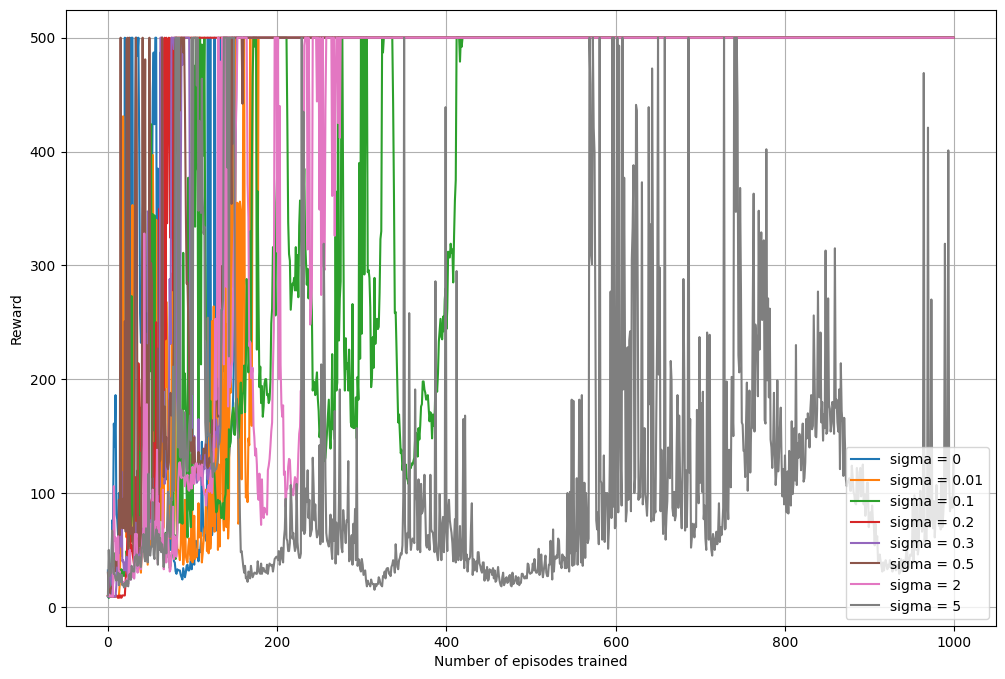

In [ ]:
fig = plt.figure(figsize=(12,8))

for i, sigma in enumerate(noise_levels):
    plt.plot(test_rewards[i], label='sigma = {}'.format(sigma))

plt.xlabel('Number of episodes trained')
plt.ylabel('Reward')

plt.legend()
plt.legend(loc='lower right')
plt.grid()
plt.show()